In [7]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import ipywidgets as widgets
from IPython.html.widgets import *
import pickle
import h5py 
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF



%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


In [8]:
# constants
DATA_PATH = '/home/ubuntu/repositories/speed-challenge/data'
TRAIN_VIDEO = os.path.join(DATA_PATH, 'train.mp4') #'drive.mp4' 'train.mp4'
TEST_VIDEO = os.path.join(DATA_PATH, 'test.mp4')
CLEAN_DATA_PATH = '/home/ubuntu/repositories/speed-challenge/prepared-data'
CLEAN_IMGS_TRAIN = os.path.join(CLEAN_DATA_PATH, 'train_imgs')
CLEAN_IMGS_TEST = os.path.join(CLEAN_DATA_PATH, 'test_imgs')
ASSETS_PATH = '/home/ubuntu/repositories/speed-challenge/assets'

train_frames = 8616 #20400 #8616
test_frames = 10798

seeds = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]


# hyperparameters
batch_size = 16
num_epochs = 25 #100 #90 
steps_per_epoch = 400

# run specific constants
model_name = 'nvidia' #nvidia2
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch)

assets_filepath = os.path.join(ASSETS_PATH, 'model_assets' , run_name)
weights_loc = os.path.join(assets_filepath,'weights.h5')
history_loc=  os.path.join(assets_filepath,'history.p')
tensorboard_loc = os.path.join(assets_filepath, run_name)



In [9]:
run_name

'model=nvidia-batch_size=16-num_epoch=25-steps_per_epoch=400'

In [10]:
train_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'train_meta.csv')) #train2_meta
print('shape: ', train_meta.shape)

shape:  (20400, 3)


In [11]:
# note: there is a chance that points might appear again. as n

def train_valid_split(dframe, seed_val):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    np.random.seed(seed_val)
    for i in tqdm(range(len(dframe) - 1)):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1
        
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [12]:
train_data, valid_data = train_valid_split(train_meta, seeds[0])

100%|██████████| 20399/20399 [01:23<00:00, 243.37it/s]


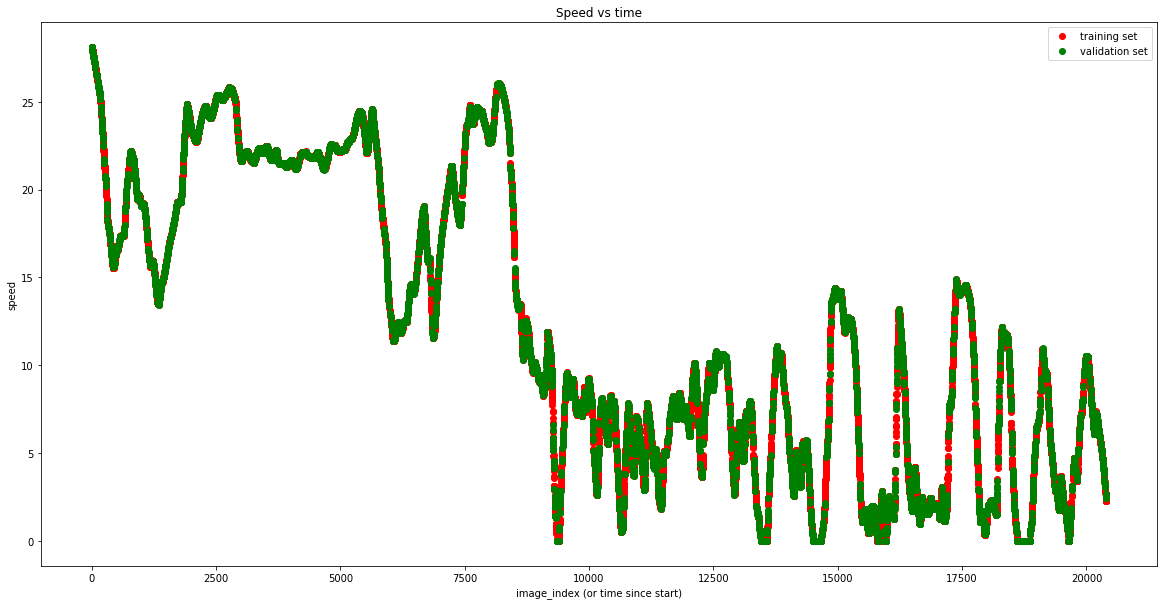

----
valid_data:  (9032, 4)
train_data:  (31766, 4)


In [13]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_data.sort_values(['image_index'])[['image_index']], train_data.sort_values(['image_index'])[['speed']], 'ro')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

print('----')
print('valid_data: ', valid_data.shape)
print('train_data: ', train_data.shape)

In [14]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [15]:
# img=mpimg.imread(train_meta['image_path'][60])
# print('original image shape:', img.shape)
# plt.imshow(img)
# plt.show()
# plt.close()

# bright_factor = 0.7 + np.random.uniform()
# print('bright_factor:', bright_factor)
# print('brightned image')
# img=mpimg.imread(train_meta['image_path'][60])
# plt.imshow(change_brightness(img, bright_factor))
# plt.show()
# plt.close()

In [16]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

In [17]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    #image_cropped = image[100:440, :-90] # -> (380, 550, 3) #v2 for data
    image_cropped = image[25:375, :] #v1 for data
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image


# def preprocess_image_2(image):
#     """
#     preprocesses the image
    
#     input: image (480 (y), 640 (x), 3) RGB
#     output: image (shape is (220, 66, 3) as RGB)
    
#     This stuff is performed on my validation data and my training data
#     Process: 
#              1) Cropping out black spots
#              3) resize to (220, 66, 3) if not done so already from perspective transform
#     """
#     # Crop out sky (top) (100px) and black right part (-90px)
#     image_cropped = image[30:400, :-90] # -> (380, 550, 3)
    
#     image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
#     return image

original image shape: (480, 640, 3)


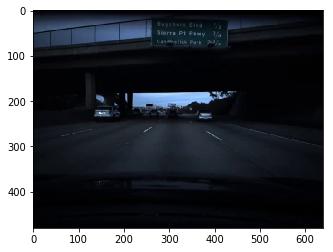

post prosessed image: (66, 220, 3)


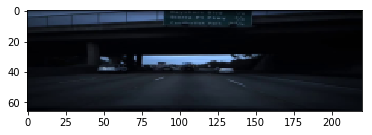

In [18]:
img=mpimg.imread(train_meta['image_path'][10])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

post_img = preprocess_image(img)
print('post prosessed image:', post_img.shape)
plt.imshow(post_img)
plt.show()
plt.close()

In [19]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)    
    img = preprocess_image(img)
    return img, speed

In [20]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, 4)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
        
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

In [21]:
def generate_validation_data(data):
    while True:
        for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')        
            
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
            
            img_diff = opticalFlowDense(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            
            #print('img_diff', img_diff.shape, ' speed', speed)
            yield img_diff, speed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.454833]]
(66, 220, 3)
255.0
-32640.0


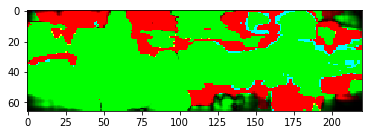

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.4602015]]
(66, 220, 3)
255.00002
-40934.445


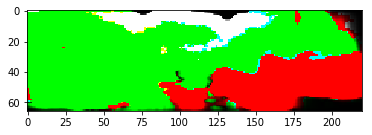

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.4602015]]
(66, 220, 3)
255.00002
-40934.445


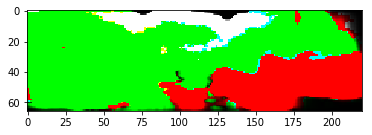

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[9.1116565]]
(66, 220, 3)
255.0
-45055.77


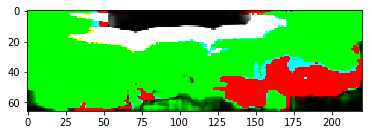

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[9.1116565]]
(66, 220, 3)
255.0
-45055.77


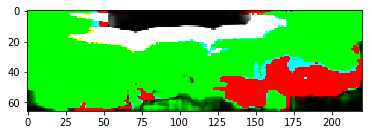

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.694571]]
(66, 220, 3)
255.0
-49193.836


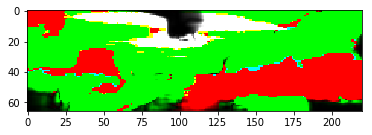

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.694571]]
(66, 220, 3)
255.0
-49193.836


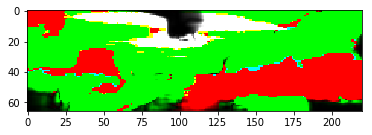

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[10.518595]]
(66, 220, 3)
255.00002
-40624.254


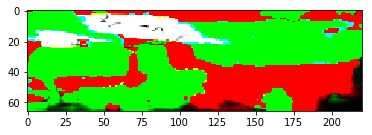

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[10.518595]]
(66, 220, 3)
255.00002
-40624.254


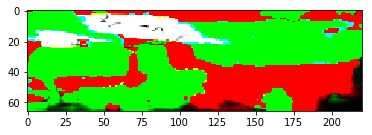

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.29936]]
(66, 220, 3)
255.0
-43273.254


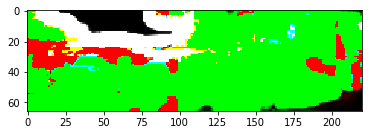

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.29936]]
(66, 220, 3)
255.0
-43273.254


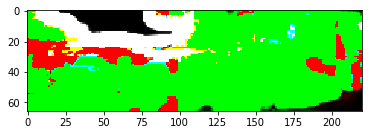

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[17.5316985]]
(66, 220, 3)
254.99998
-31735.504


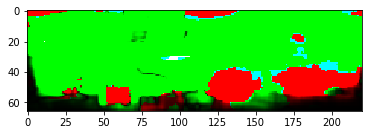

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[17.5316985]]
(66, 220, 3)
254.99998
-31735.504


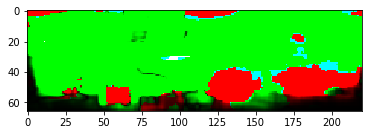

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.799687]]
(66, 220, 3)
255.0
-29478.982


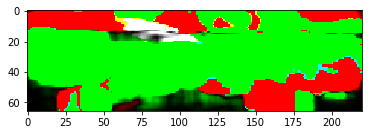

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.799687]]
(66, 220, 3)
255.0
-29478.982


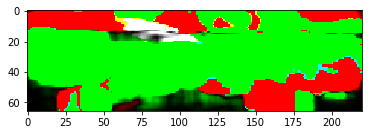

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[15.9181655]]
(66, 220, 3)
255.0
-29281.557


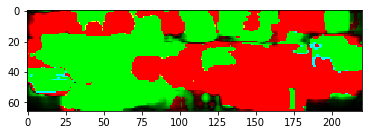

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[15.9181655]]
(66, 220, 3)
255.0
-29281.557


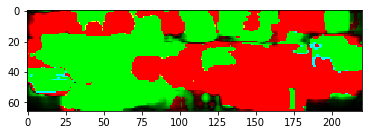

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.919506]]
(66, 220, 3)
255.0
-35955.0


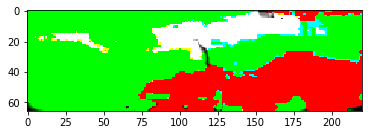

(1, 66, 220, 3)
[[1.919506]]
(66, 220, 3)
255.0
-35955.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


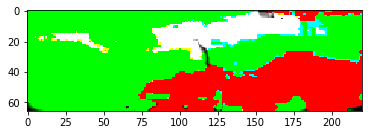

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.133411]]
(66, 220, 3)
255.0
-48359.285


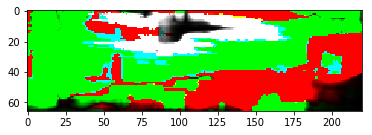

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.133411]]
(66, 220, 3)
255.0
-48359.285


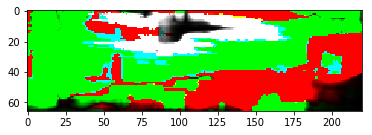

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[13.4749]]
(66, 220, 3)
254.99998
-28304.998


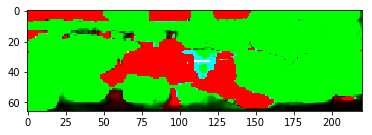

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[13.4749]]
(66, 220, 3)
254.99998
-28304.998


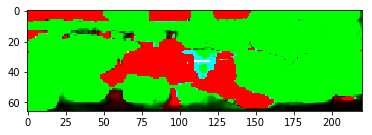

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[17.576815]]
(66, 220, 3)
254.99998
-38530.25


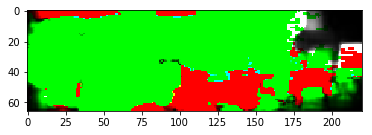

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[17.576815]]
(66, 220, 3)
254.99998
-38530.25


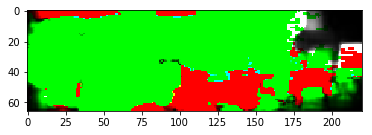

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[9.595696]]
(66, 220, 3)
255.0
-29180.57


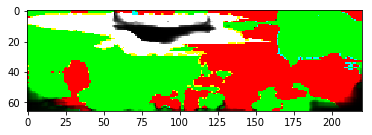

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[9.595696]]
(66, 220, 3)
255.0
-29180.57


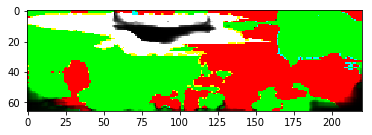

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-35583.465


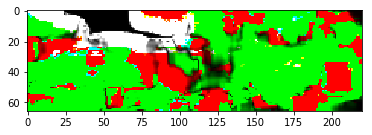

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-35583.465


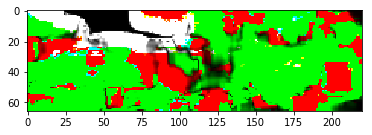

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[10.92284]]
(66, 220, 3)
255.0
-38370.766


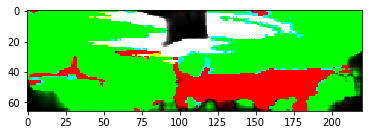

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[10.92284]]
(66, 220, 3)
255.0
-38370.766


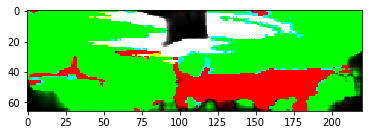

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[13.975579]]
(66, 220, 3)
255.0
-42805.246


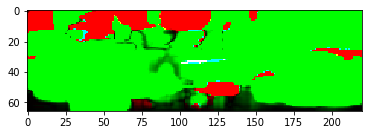

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[13.975579]]
(66, 220, 3)
255.0
-42805.246


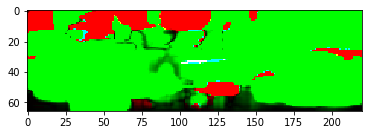

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[19.1153075]]
(66, 220, 3)
255.0
-45348.953


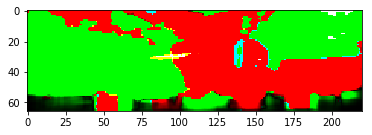

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[19.1153075]]
(66, 220, 3)
255.0
-45348.953


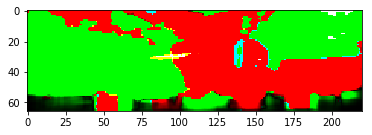

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[2.0018445]]
(66, 220, 3)
255.0
-36426.12


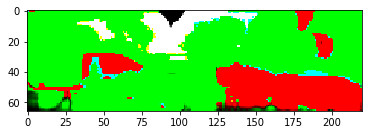

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[2.0018445]]
(66, 220, 3)
255.0
-36426.12


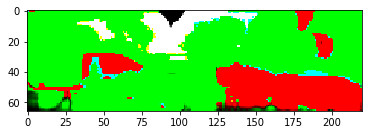

(1, 66, 220, 3)
[[22.0938215]]
(66, 220, 3)
255.0
-32616.508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


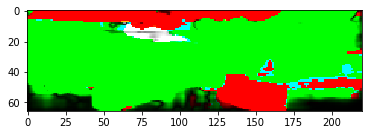

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.0938215]]
(66, 220, 3)
255.0
-32616.508


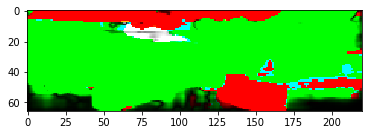

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[5.829005]]
(66, 220, 3)
255.0
-34211.836


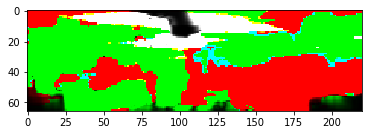

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[5.829005]]
(66, 220, 3)
255.0
-34211.836


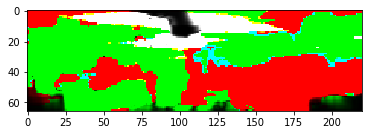

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.70367]]
(66, 220, 3)
255.00002
-40290.004


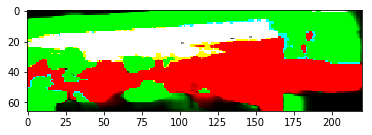

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.70367]]
(66, 220, 3)
255.00002
-40290.004


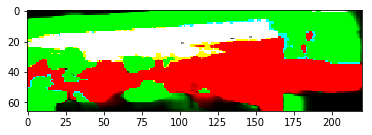

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[18.5690175]]
(66, 220, 3)
255.0
-49182.168


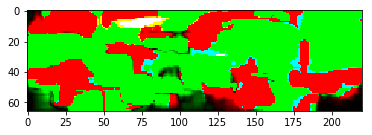

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[18.5690175]]
(66, 220, 3)
255.0
-49182.168


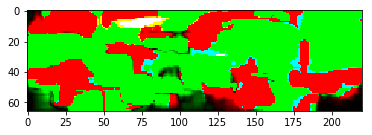

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.5874945]]
(66, 220, 3)
255.0
-33004.984


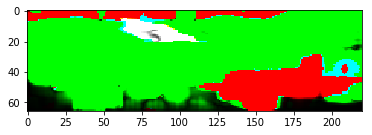

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.5874945]]
(66, 220, 3)
255.0
-33004.984


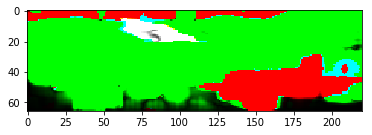

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[18.328254]]
(66, 220, 3)
255.0
-49121.82


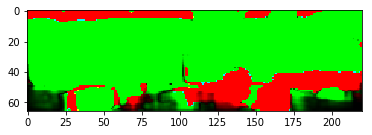

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[18.328254]]
(66, 220, 3)
255.0
-49121.82


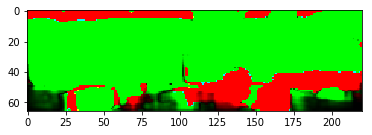

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.105074]]
(66, 220, 3)
255.0
-34630.062


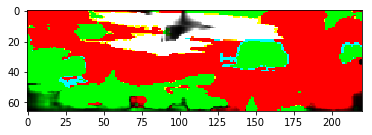

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.105074]]
(66, 220, 3)
255.0
-34630.062


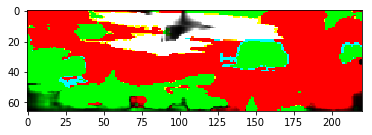

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[4.0359415]]
(66, 220, 3)
255.00002
-47705.83


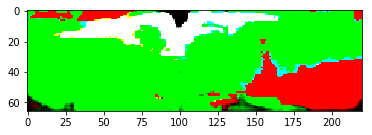

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[4.0359415]]
(66, 220, 3)
255.00002
-47705.83


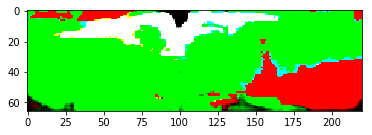

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[15.857186]]
(66, 220, 3)
255.00002
-37929.027


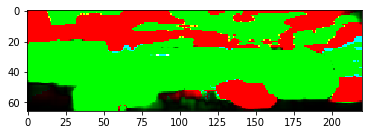

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[15.857186]]
(66, 220, 3)
255.00002
-37929.027


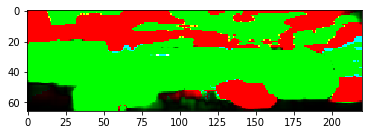

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.129161]]
(66, 220, 3)
255.0
-46380.62


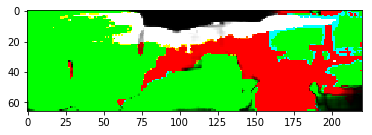

(1, 66, 220, 3)
[[1.129161]]
(66, 220, 3)
255.0
-46380.62


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


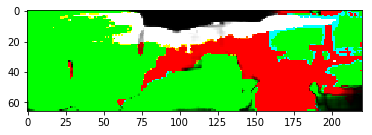

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.4502185]]
(66, 220, 3)
255.0
-30876.783


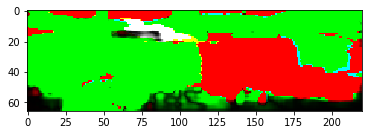

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.4502185]]
(66, 220, 3)
255.0
-30876.783


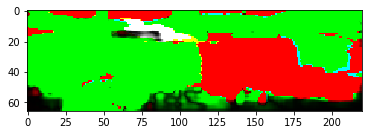

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[20.3918395]]
(66, 220, 3)
255.0
-29303.254


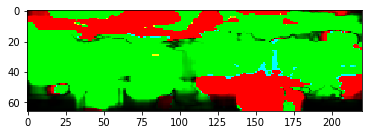

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[20.3918395]]
(66, 220, 3)
255.0
-29303.254


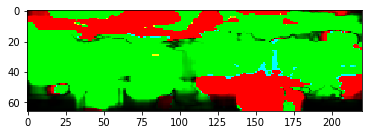

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[11.9153025]]
(66, 220, 3)
255.0
-32130.24


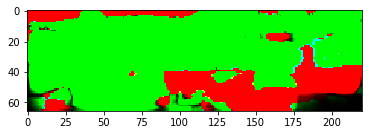

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[11.9153025]]
(66, 220, 3)
255.0
-32130.24


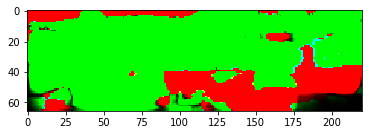

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.4740975]]
(66, 220, 3)
255.0
-34035.6


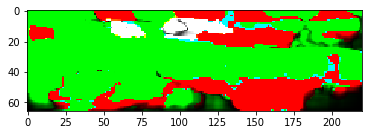

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.4740975]]
(66, 220, 3)
255.0
-34035.6


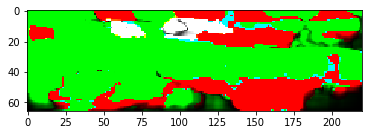

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.210377]]
(66, 220, 3)
255.0
-31033.855


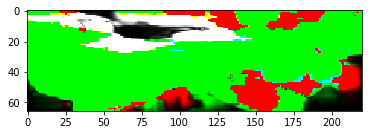

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.210377]]
(66, 220, 3)
255.0
-31033.855


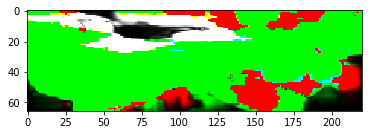

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[9.223694]]
(66, 220, 3)
255.00002
-31509.95


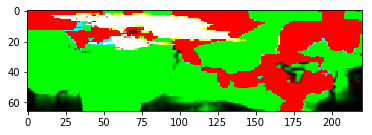

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[9.223694]]
(66, 220, 3)
255.00002
-31509.95


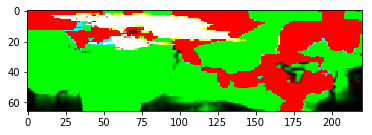

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.7717105]]
(66, 220, 3)
255.0
-34341.844


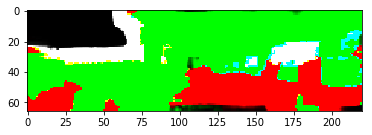

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.7717105]]
(66, 220, 3)
255.0
-34341.844


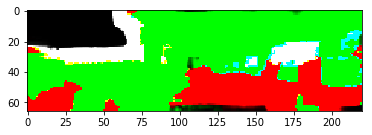

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.867006]]
(66, 220, 3)
255.0
-46102.984


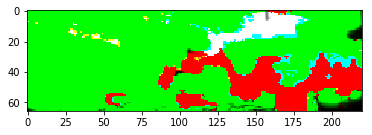

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.867006]]
(66, 220, 3)
255.0
-46102.984


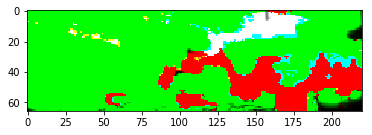

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.8222835]]
(66, 220, 3)
255.0
-34180.344


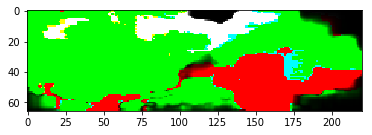

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.8222835]]
(66, 220, 3)
255.0
-34180.344


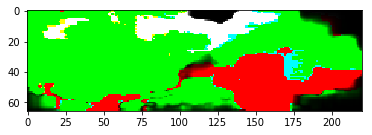

(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-59671.945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


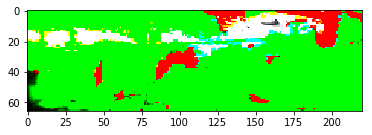

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-59671.945


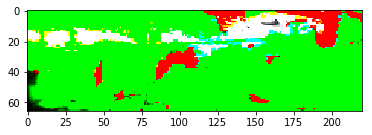

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.6751015]]
(66, 220, 3)
255.0
-29384.63


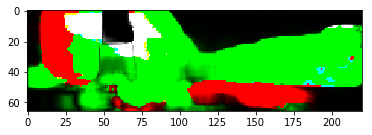

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.6751015]]
(66, 220, 3)
255.0
-29384.63


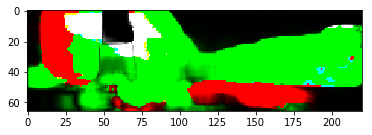

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[3.633401]]
(66, 220, 3)
255.0
-43539.023


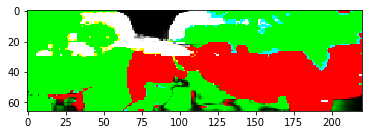

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[3.633401]]
(66, 220, 3)
255.0
-43539.023


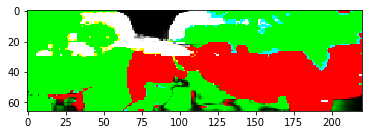

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.7216145]]
(66, 220, 3)
255.00002
-31105.137


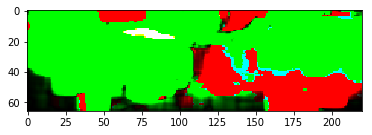

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.7216145]]
(66, 220, 3)
255.00002
-31105.137


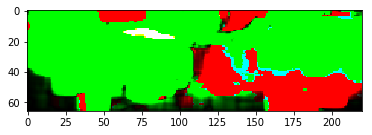

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[4.7732235]]
(66, 220, 3)
255.0
-37832.17


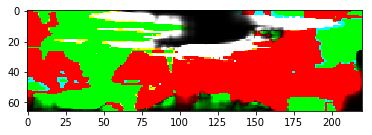

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[4.7732235]]
(66, 220, 3)
255.0
-37832.17


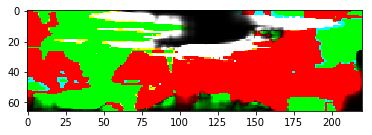

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.927398]]
(66, 220, 3)
255.0
-30090.0


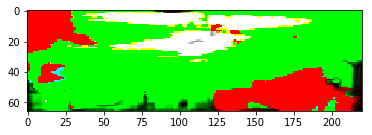

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.927398]]
(66, 220, 3)
255.0
-30090.0


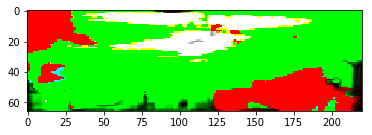

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.434784]]
(66, 220, 3)
255.00002
-33272.08


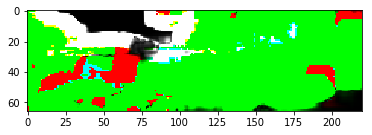

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.434784]]
(66, 220, 3)
255.00002
-33272.08


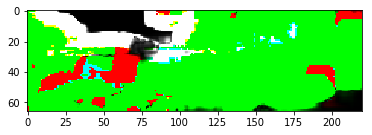

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[14.148287]]
(66, 220, 3)
255.0
-31018.006


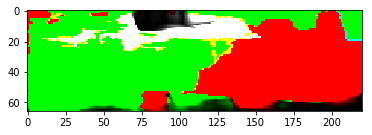

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[14.148287]]
(66, 220, 3)
255.0
-31018.006


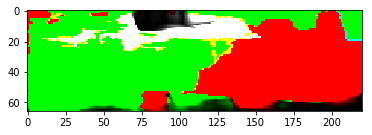

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[20.498496]]
(66, 220, 3)
255.0
-32982.934


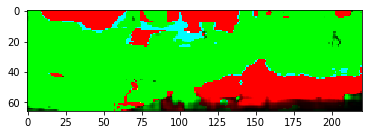

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[20.498496]]
(66, 220, 3)
255.0
-32982.934


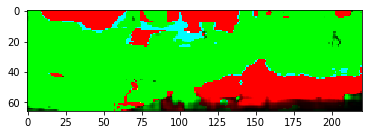

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.724807]]
(66, 220, 3)
255.0
-42055.97


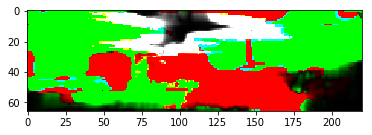

(1, 66, 220, 3)
[[8.724807]]
(66, 220, 3)
255.0
-42055.97


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


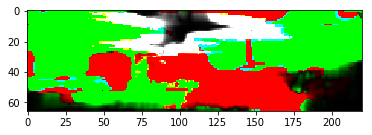

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[11.4718505]]
(66, 220, 3)
255.0
-61061.332


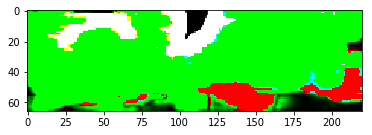

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[11.4718505]]
(66, 220, 3)
255.0
-61061.332


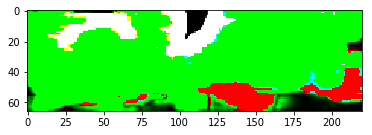

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.9746845]]
(66, 220, 3)
255.0
-52901.0


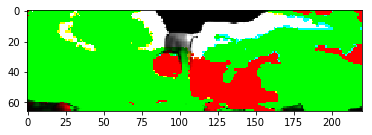

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.9746845]]
(66, 220, 3)
255.0
-52901.0


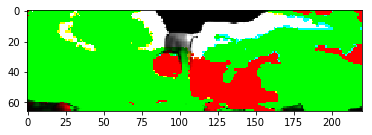

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[3.611946]]
(66, 220, 3)
255.0
-26691.162


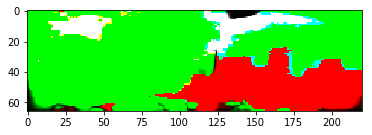

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[3.611946]]
(66, 220, 3)
255.0
-26691.162


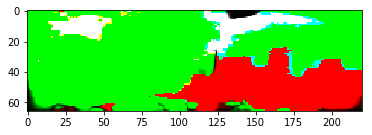

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.7486335]]
(66, 220, 3)
255.0
-34425.0


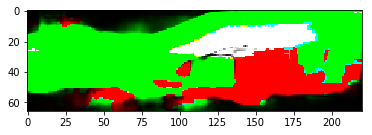

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.7486335]]
(66, 220, 3)
255.0
-34425.0


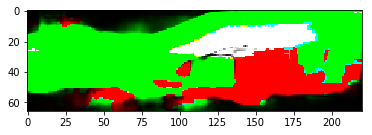

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[16.547723]]
(66, 220, 3)
255.00002
-29628.285


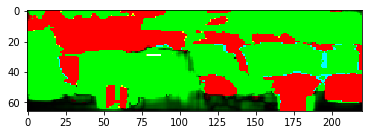

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[16.547723]]
(66, 220, 3)
255.00002
-29628.285


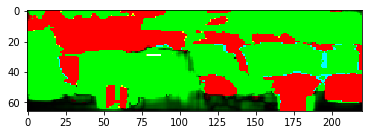

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.187654]]
(66, 220, 3)
255.00002
-38389.297


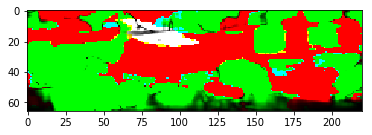

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.187654]]
(66, 220, 3)
255.00002
-38389.297


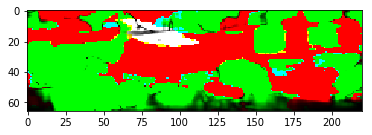

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.463387]]
(66, 220, 3)
255.0
-23992.377


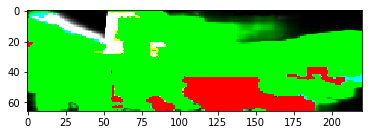

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.463387]]
(66, 220, 3)
255.0
-23992.377


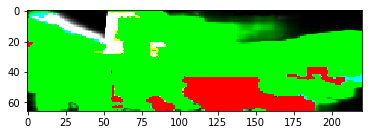

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[19.250375]]
(66, 220, 3)
255.00002
-30397.537


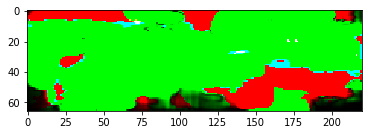

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[19.250375]]
(66, 220, 3)
255.00002
-30397.537


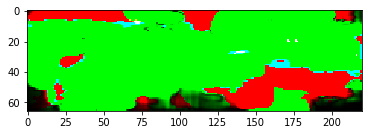

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.856272]]
(66, 220, 3)
255.0
-43309.246


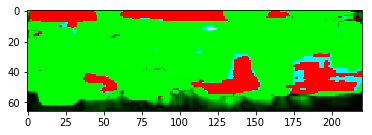

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.856272]]
(66, 220, 3)
255.0
-43309.246


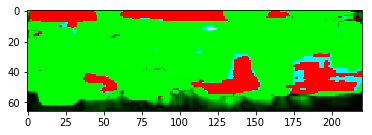

(1, 66, 220, 3)
[[4.7405665]]
(66, 220, 3)
255.0
-54604.805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


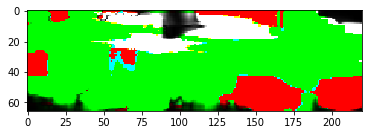

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[4.7405665]]
(66, 220, 3)
255.0
-54604.805


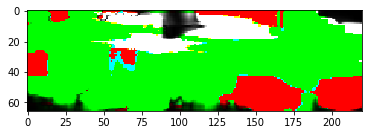

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-21930.0


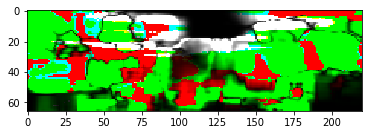

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-21930.0


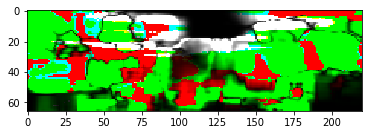

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-35093.914


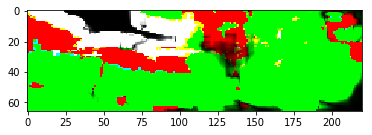

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-35093.914


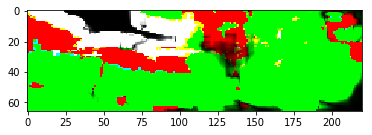

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[9.614785]]
(66, 220, 3)
255.00002
-34929.137


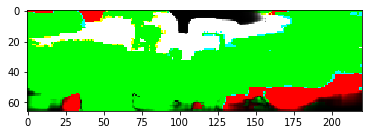

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[9.614785]]
(66, 220, 3)
255.00002
-34929.137


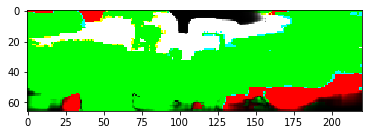

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[15.6459375]]
(66, 220, 3)
255.0
-41032.906


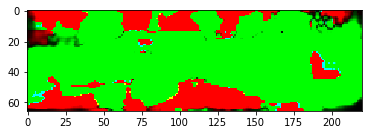

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[15.6459375]]
(66, 220, 3)
255.0
-41032.906


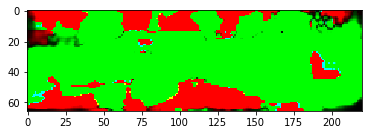

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.2312565]]
(66, 220, 3)
254.99998
-31712.371


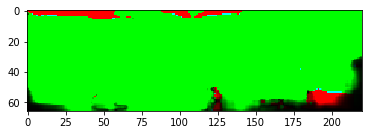

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.2312565]]
(66, 220, 3)
254.99998
-31712.371


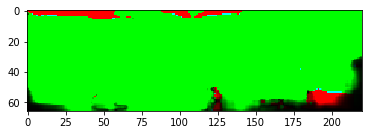

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.382988]]
(66, 220, 3)
255.00002
-33180.387


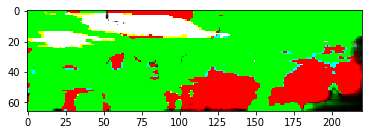

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.382988]]
(66, 220, 3)
255.00002
-33180.387


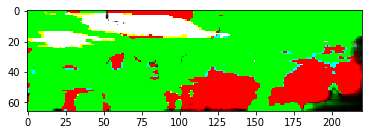

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.9573535]]
(66, 220, 3)
255.00002
-29102.154


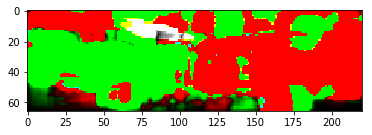

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.9573535]]
(66, 220, 3)
255.00002
-29102.154


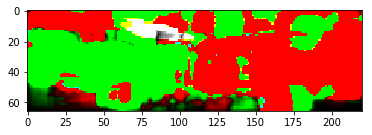

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[3.841051]]
(66, 220, 3)
255.0
-52211.746


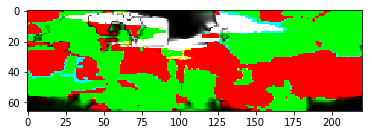

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[3.841051]]
(66, 220, 3)
255.0
-52211.746


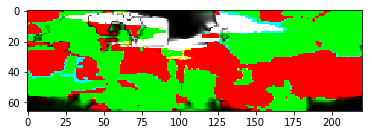

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.7310635]]
(66, 220, 3)
254.99998
-25872.373


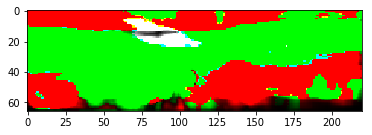

(1, 66, 220, 3)
[[22.7310635]]
(66, 220, 3)
254.99998
-25872.373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


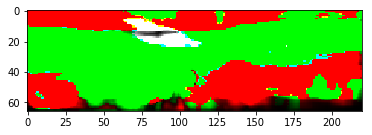

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[20.237488]]
(66, 220, 3)
255.00002
-42469.316


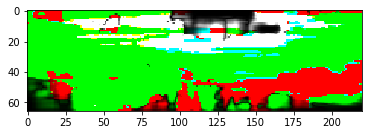

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[20.237488]]
(66, 220, 3)
255.00002
-42469.316


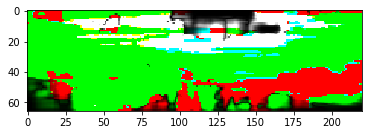

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[14.210366]]
(66, 220, 3)
254.99998
-28602.387


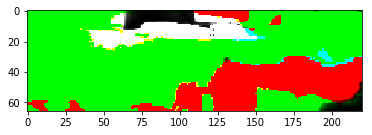

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[14.210366]]
(66, 220, 3)
254.99998
-28602.387


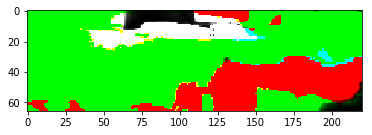

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.7478125]]
(66, 220, 3)
255.00002
-45189.137


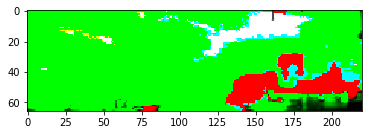

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.7478125]]
(66, 220, 3)
255.00002
-45189.137


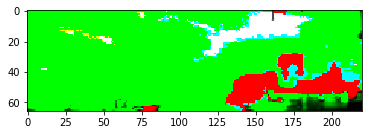

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.5055465]]
(66, 220, 3)
255.0
-60901.63


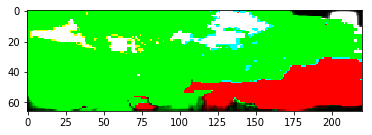

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.5055465]]
(66, 220, 3)
255.0
-60901.63


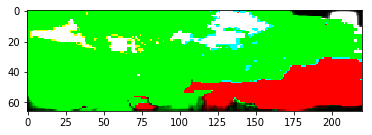

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.547476]]
(66, 220, 3)
255.0
-41346.348


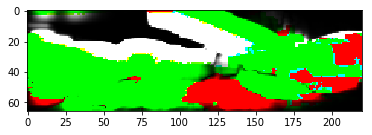

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.547476]]
(66, 220, 3)
255.0
-41346.348


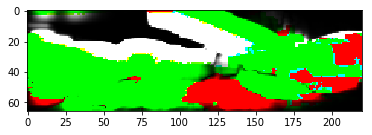

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.129315]]
(66, 220, 3)
255.0
-31649.898


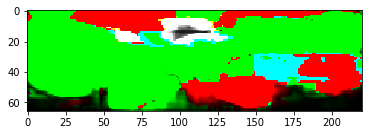

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.129315]]
(66, 220, 3)
255.0
-31649.898


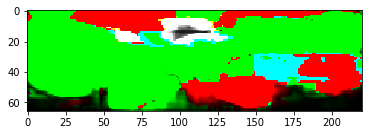

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.9851455]]
(66, 220, 3)
254.99998
-43278.918


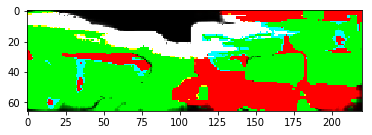

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.9851455]]
(66, 220, 3)
254.99998
-43278.918


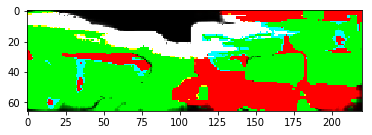

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.7420055]]
(66, 220, 3)
254.99998
-40231.555


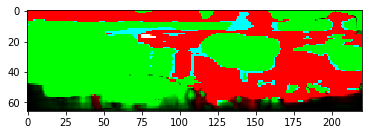

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.7420055]]
(66, 220, 3)
254.99998
-40231.555


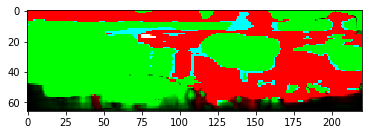

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[4.0213705]]
(66, 220, 3)
255.0
-39332.664


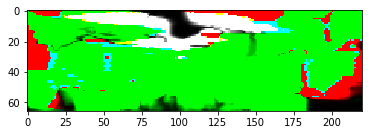

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[4.0213705]]
(66, 220, 3)
255.0
-39332.664


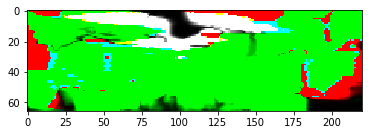

(1, 66, 220, 3)
[[13.238633]]
(66, 220, 3)
255.0
-38764.74


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


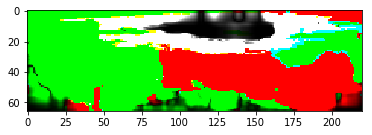

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[13.238633]]
(66, 220, 3)
255.0
-38764.74


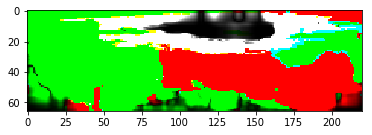

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[2.1479335]]
(66, 220, 3)
255.00002
-24990.002


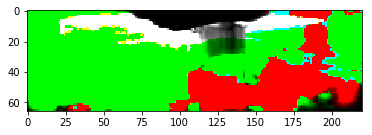

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[2.1479335]]
(66, 220, 3)
255.00002
-24990.002


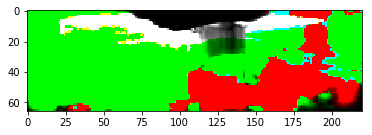

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[10.289732]]
(66, 220, 3)
255.0
-64770.0


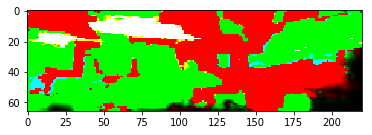

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[10.289732]]
(66, 220, 3)
255.0
-64770.0


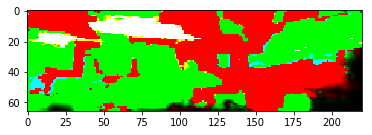

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[12.06144]]
(66, 220, 3)
254.99998
-49779.953


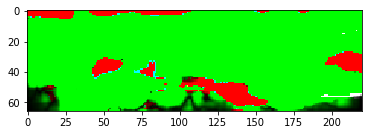

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[12.06144]]
(66, 220, 3)
254.99998
-49779.953


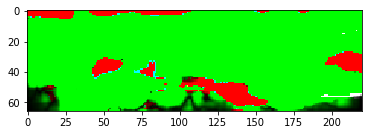

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.6801045]]
(66, 220, 3)
255.0
-46357.117


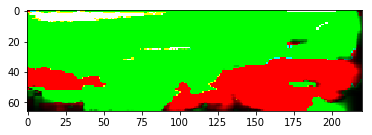

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.6801045]]
(66, 220, 3)
255.0
-46357.117


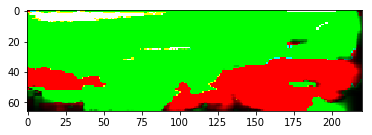

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[5.4830435]]
(66, 220, 3)
255.00002
-35868.363


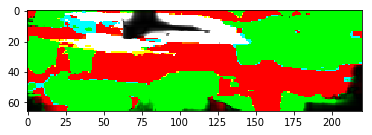

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[5.4830435]]
(66, 220, 3)
255.00002
-35868.363


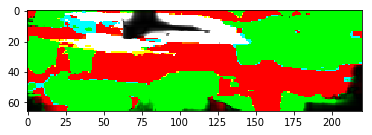

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.560173]]
(66, 220, 3)
255.0
-45713.344


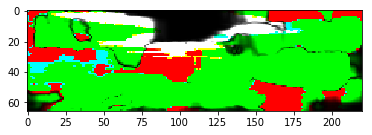

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.560173]]
(66, 220, 3)
255.0
-45713.344


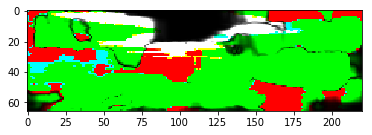

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.522111]]
(66, 220, 3)
255.0
-38228.098


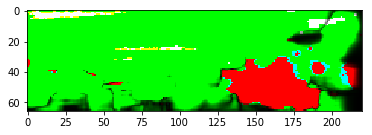

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.522111]]
(66, 220, 3)
255.0
-38228.098


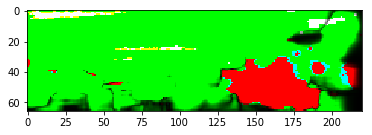

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.805823]]
(66, 220, 3)
255.0
-28054.322


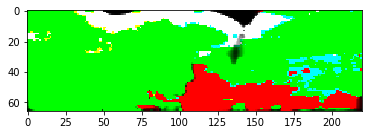

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.805823]]
(66, 220, 3)
255.0
-28054.322


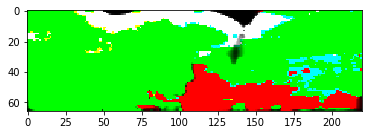

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.44455]]
(66, 220, 3)
254.99998
-29960.01


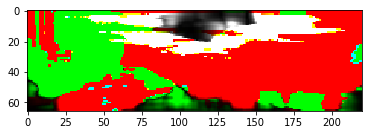

(1, 66, 220, 3)
[[24.44455]]
(66, 220, 3)
254.99998
-29960.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


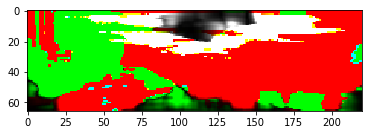

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[2.731938]]
(66, 220, 3)
255.0
-20330.895


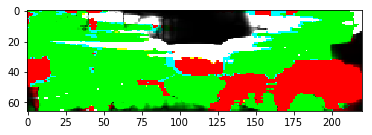

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[2.731938]]
(66, 220, 3)
255.0
-20330.895


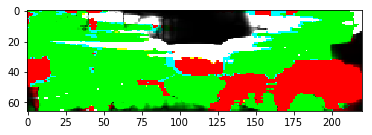

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[20.4531565]]
(66, 220, 3)
255.0
-55101.156


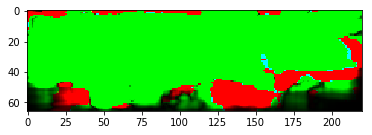

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[20.4531565]]
(66, 220, 3)
255.0
-55101.156


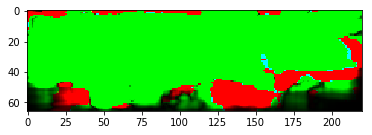

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[19.5259345]]
(66, 220, 3)
255.0
-32258.059


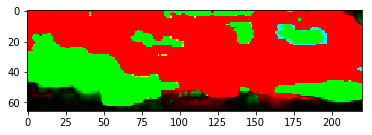

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[19.5259345]]
(66, 220, 3)
255.0
-32258.059


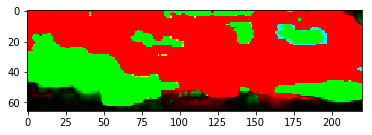

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[5.2569115]]
(66, 220, 3)
255.0
-32369.555


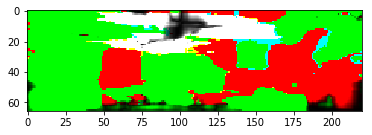

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[5.2569115]]
(66, 220, 3)
255.0
-32369.555


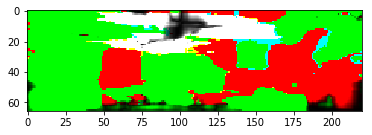

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.798857]]
(66, 220, 3)
255.0
-52526.3


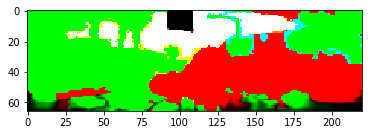

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.798857]]
(66, 220, 3)
255.0
-52526.3


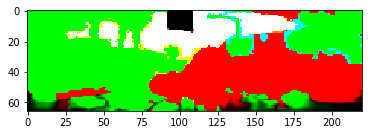

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.7271075]]
(66, 220, 3)
255.0
-26257.904


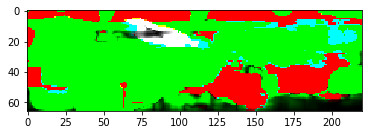

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.7271075]]
(66, 220, 3)
255.0
-26257.904


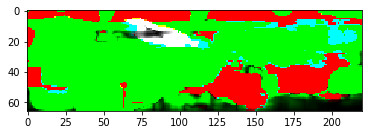

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[4.903354]]
(66, 220, 3)
255.0
-49044.363


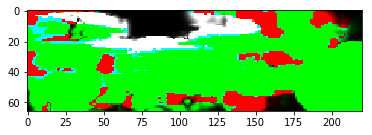

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[4.903354]]
(66, 220, 3)
255.0
-49044.363


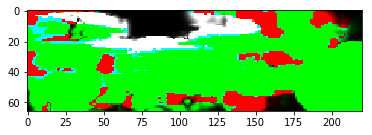

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-32924.004


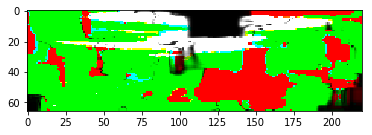

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-32924.004


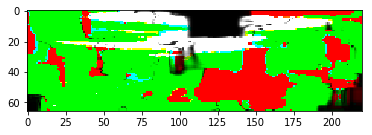

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[5.9970115]]
(66, 220, 3)
255.0
-23715.0


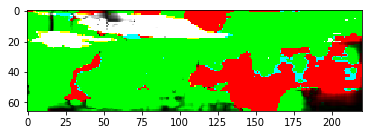

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[5.9970115]]
(66, 220, 3)
255.0
-23715.0


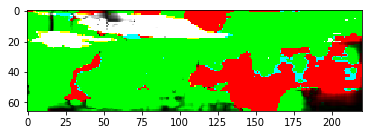

(1, 66, 220, 3)
[[11.7105]]
(66, 220, 3)
255.0
-39862.977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


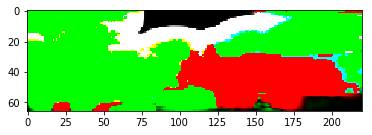

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[11.7105]]
(66, 220, 3)
255.0
-39862.977


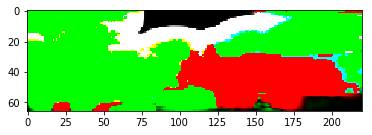

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.9670095]]
(66, 220, 3)
254.99998
-40368.977


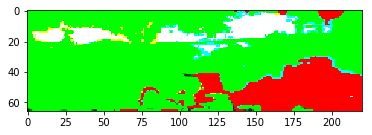

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.9670095]]
(66, 220, 3)
254.99998
-40368.977


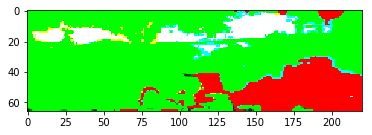

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.648917]]
(66, 220, 3)
255.00002
-40065.8


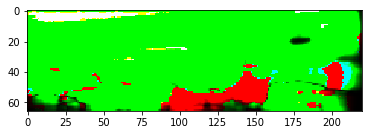

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.648917]]
(66, 220, 3)
255.00002
-40065.8


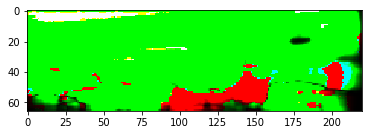

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[11.6760055]]
(66, 220, 3)
255.0
-36379.945


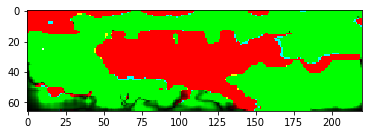

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[11.6760055]]
(66, 220, 3)
255.0
-36379.945


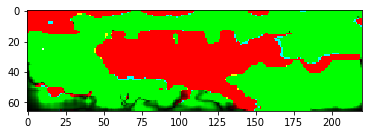

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.7214935]]
(66, 220, 3)
255.0
-21941.271


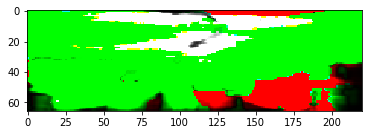

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.7214935]]
(66, 220, 3)
255.0
-21941.271


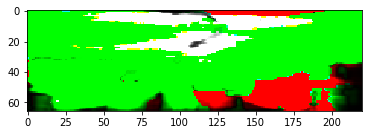

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.4740975]]
(66, 220, 3)
255.0
-34035.6


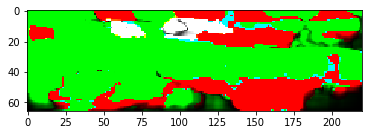

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.4740975]]
(66, 220, 3)
255.0
-34035.6


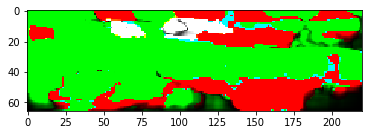

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[11.75555]]
(66, 220, 3)
255.0
-38512.83


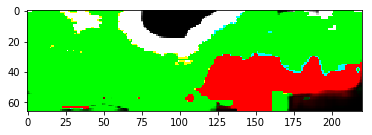

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[11.75555]]
(66, 220, 3)
255.0
-38512.83


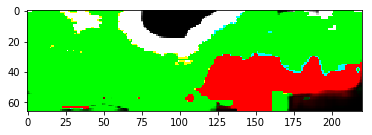

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.5644585]]
(66, 220, 3)
255.0
-34479.227


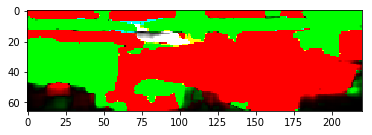

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.5644585]]
(66, 220, 3)
255.0
-34479.227


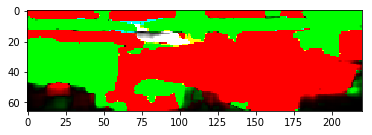

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.1549155]]
(66, 220, 3)
255.0
-36578.605


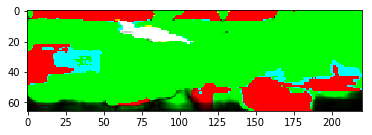

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.1549155]]
(66, 220, 3)
255.0
-36578.605


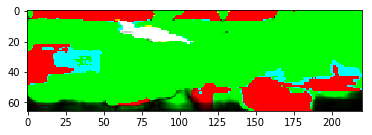

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[4.9790905]]
(66, 220, 3)
255.0
-23466.195


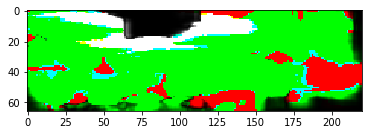

(1, 66, 220, 3)
[[4.9790905]]
(66, 220, 3)
255.0
-23466.195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


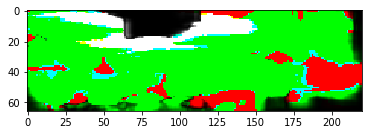

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.558724]]
(66, 220, 3)
255.00002
-36166.562


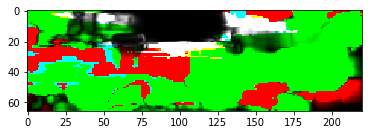

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.558724]]
(66, 220, 3)
255.00002
-36166.562


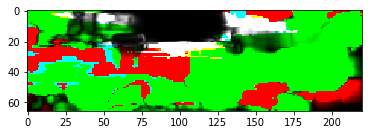

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.639926]]
(66, 220, 3)
255.00002
-35574.9


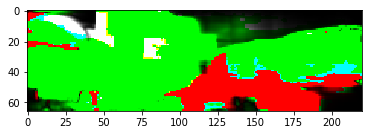

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.639926]]
(66, 220, 3)
255.00002
-35574.9


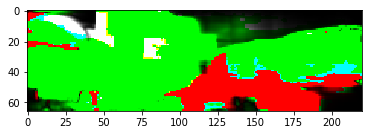

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.732498]]
(66, 220, 3)
255.0
-25842.797


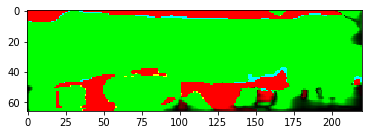

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.732498]]
(66, 220, 3)
255.0
-25842.797


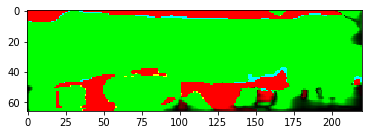

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[18.244188]]
(66, 220, 3)
255.0
-29600.525


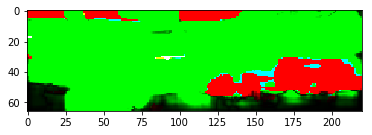

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[18.244188]]
(66, 220, 3)
255.0
-29600.525


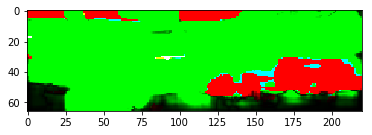

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.980019]]
(66, 220, 3)
255.0
-38694.242


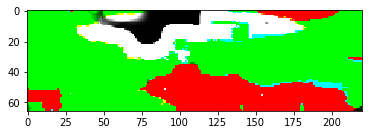

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.980019]]
(66, 220, 3)
255.0
-38694.242


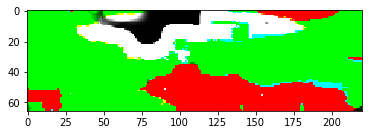

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.872069]]
(66, 220, 3)
255.00002
-43047.348


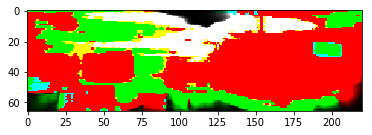

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.872069]]
(66, 220, 3)
255.00002
-43047.348


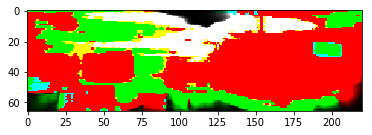

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-40288.445


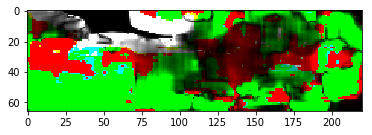

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-40288.445


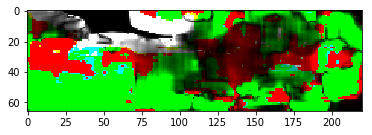

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[15.7749965]]
(66, 220, 3)
254.99998
-27624.186


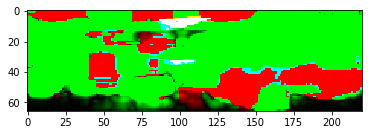

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[15.7749965]]
(66, 220, 3)
254.99998
-27624.186


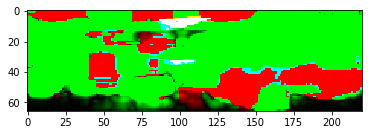

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.966748]]
(66, 220, 3)
254.99998
-54601.363


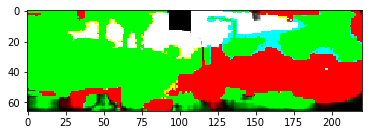

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.966748]]
(66, 220, 3)
254.99998
-54601.363


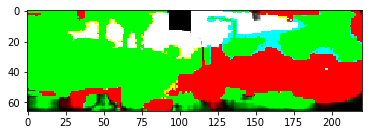

(1, 66, 220, 3)
[[0.7355845]]
(66, 220, 3)
255.0
-28069.758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


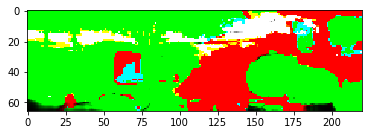

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.7355845]]
(66, 220, 3)
255.0
-28069.758


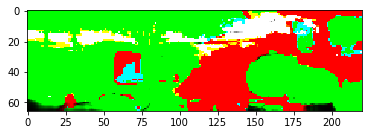

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.469996]]
(66, 220, 3)
255.0
-34124.27


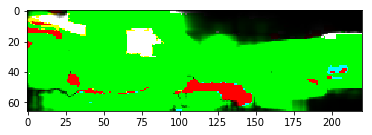

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.469996]]
(66, 220, 3)
255.0
-34124.27


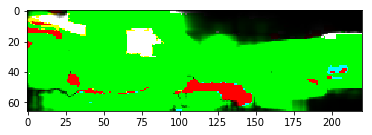

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.564587]]
(66, 220, 3)
255.0
-30736.582


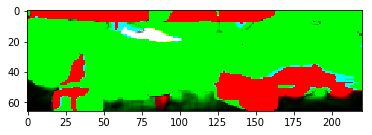

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.564587]]
(66, 220, 3)
255.0
-30736.582


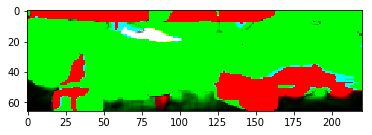

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[9.6330305]]
(66, 220, 3)
255.0
-26920.605


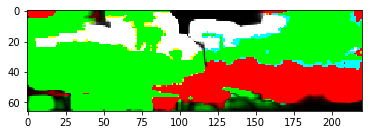

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[9.6330305]]
(66, 220, 3)
255.0
-26920.605


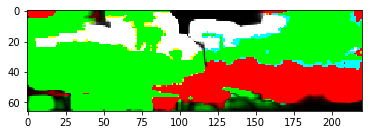

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[5.0938025]]
(66, 220, 3)
255.0
-28693.225


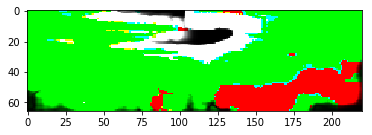

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[5.0938025]]
(66, 220, 3)
255.0
-28693.225


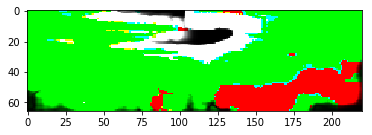

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[10.559818]]
(66, 220, 3)
255.0
-39987.977


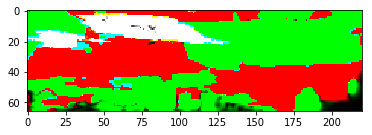

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[10.559818]]
(66, 220, 3)
255.0
-39987.977


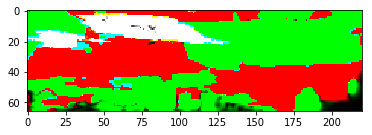

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.384456]]
(66, 220, 3)
255.0
-39778.277


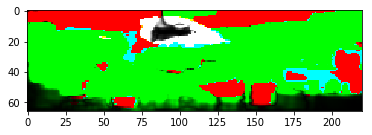

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.384456]]
(66, 220, 3)
255.0
-39778.277


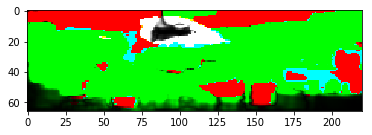

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[25.24737]]
(66, 220, 3)
255.0
-43938.277


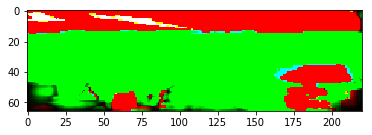

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[25.24737]]
(66, 220, 3)
255.0
-43938.277


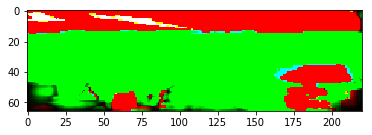

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.798185]]
(66, 220, 3)
254.99998
-48045.723


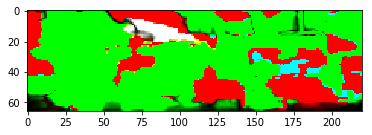

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.798185]]
(66, 220, 3)
254.99998
-48045.723


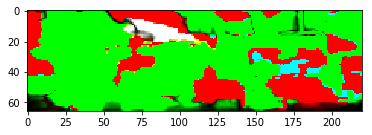

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.3804525]]
(66, 220, 3)
254.99998
-43724.203


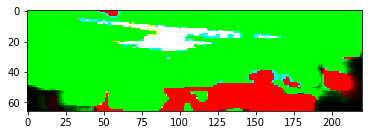

(1, 66, 220, 3)
[[6.3804525]]
(66, 220, 3)
254.99998
-43724.203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


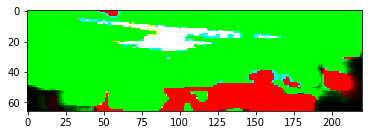

(1, 66, 220, 3)
[[8.1761665]]
(66, 220, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


255.0
-50324.688


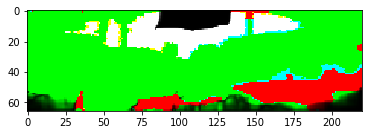

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.1761665]]
(66, 220, 3)
255.0
-50324.688


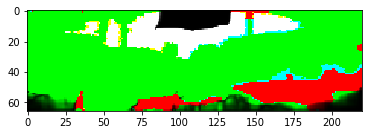

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[18.842556]]
(66, 220, 3)
255.00002
-44639.156


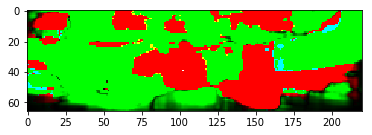

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[18.842556]]
(66, 220, 3)
255.00002
-44639.156


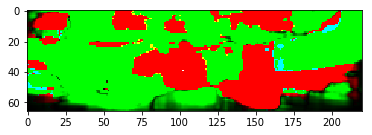

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[19.3374385]]
(66, 220, 3)
255.0
-44704.387


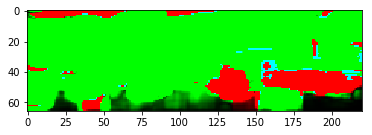

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[19.3374385]]
(66, 220, 3)
255.0
-44704.387


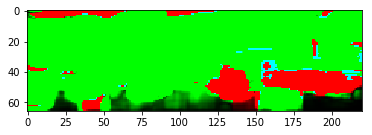

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[11.7634015]]
(66, 220, 3)
255.0
-38613.723


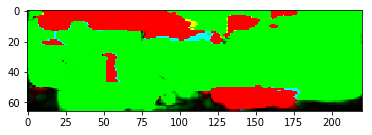

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[11.7634015]]
(66, 220, 3)
255.0
-38613.723


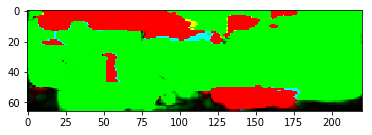

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[18.4035215]]
(66, 220, 3)
254.99998
-33375.305


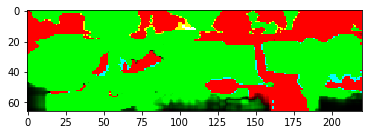

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[18.4035215]]
(66, 220, 3)
254.99998
-33375.305


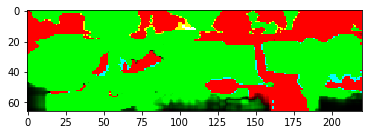

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[17.226126]]
(66, 220, 3)
254.99998
-33780.79


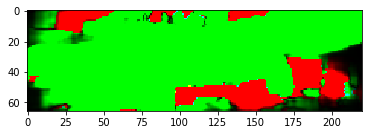

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[17.226126]]
(66, 220, 3)
254.99998
-33780.79


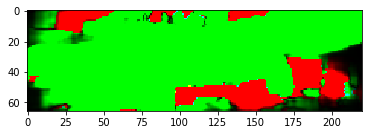

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.00002
-21930.002


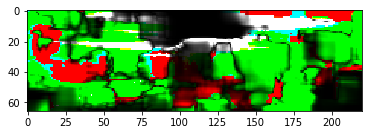

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.00002
-21930.002


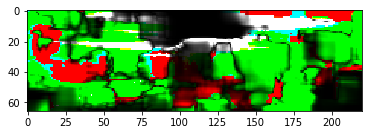

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[25.325857]]
(66, 220, 3)
255.0
-53863.44


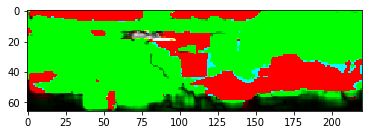

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[25.325857]]
(66, 220, 3)
255.0
-53863.44


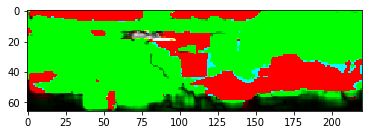

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.507496]]
(66, 220, 3)
255.0
-44159.83


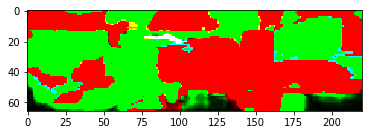

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.507496]]
(66, 220, 3)
255.0
-44159.83


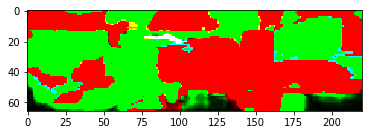

(1, 66, 220, 3)
[[11.806294]]
(66, 220, 3)
255.00002
-33851.734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


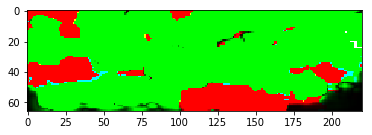

(1, 66, 220, 3)
[[11.806294]]
(66, 220, 3)
255.00002
-33851.734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


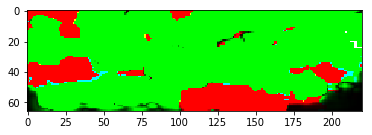

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-26128.232


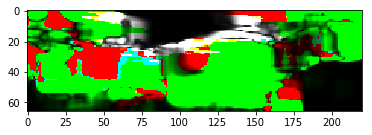

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.]]
(66, 220, 3)
255.0
-26128.232


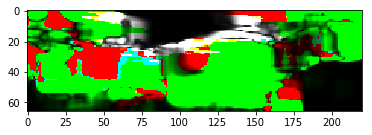

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.4840015]]
(66, 220, 3)
255.0
-35964.28


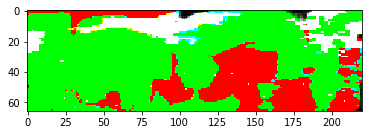

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[1.4840015]]
(66, 220, 3)
255.0
-35964.28


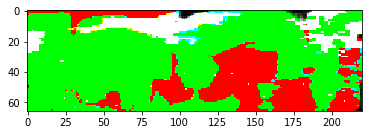

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.945489]]
(66, 220, 3)
254.99998
-30936.889


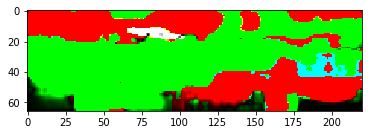

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.945489]]
(66, 220, 3)
254.99998
-30936.889


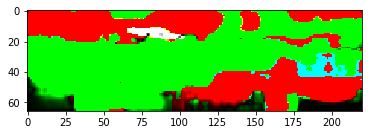

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.8371495]]
(66, 220, 3)
254.99998
-35764.355


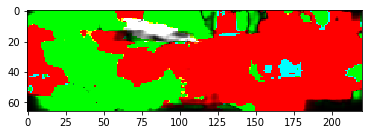

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.8371495]]
(66, 220, 3)
254.99998
-35764.355


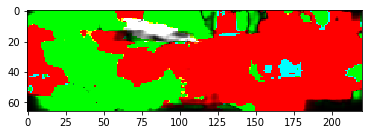

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[12.983337]]
(66, 220, 3)
255.0
-27505.225


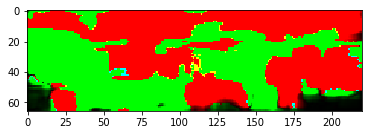

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[12.983337]]
(66, 220, 3)
255.0
-27505.225


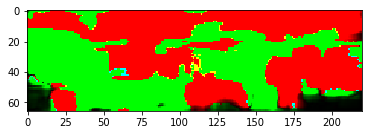

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.4191655]]
(66, 220, 3)
255.0
-27110.63


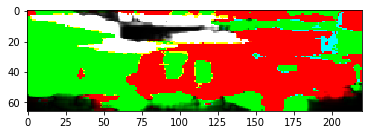

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.4191655]]
(66, 220, 3)
255.0
-27110.63


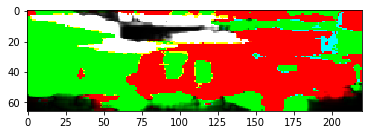

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.1761665]]
(66, 220, 3)
255.0
-50324.688


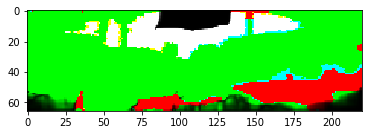

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.1761665]]
(66, 220, 3)
255.0
-50324.688


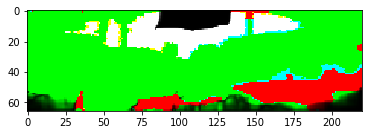

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.9509415]]
(66, 220, 3)
255.0
-42980.297


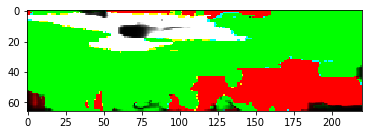

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.9509415]]
(66, 220, 3)
255.0
-42980.297


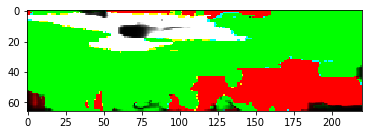

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[2.642022]]
(66, 220, 3)
255.0
-23475.041


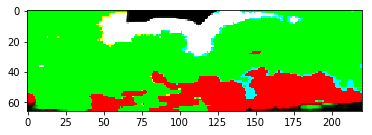

(1, 66, 220, 3)
[[2.642022]]
(66, 220, 3)
255.0
-23475.041


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


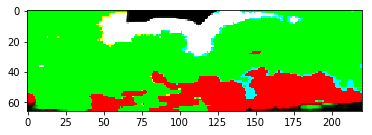

(1, 66, 220, 3)
[[6.7968015]]
(66, 220, 3)
255.0
-52461.305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


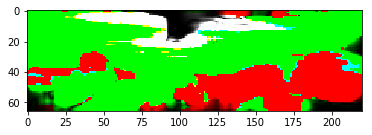

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.7968015]]
(66, 220, 3)
255.0
-52461.305


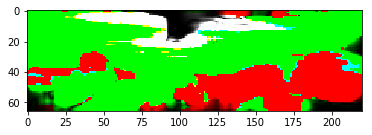

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.248859]]
(66, 220, 3)
255.0
-23825.822


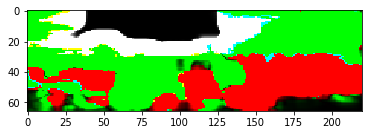

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.248859]]
(66, 220, 3)
255.0
-23825.822


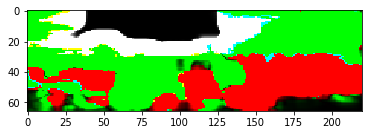

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[19.6994835]]
(66, 220, 3)
255.00002
-28124.535


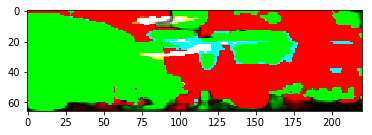

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[19.6994835]]
(66, 220, 3)
255.00002
-28124.535


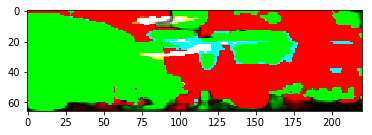

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[13.4855325]]
(66, 220, 3)
255.0
-46660.598


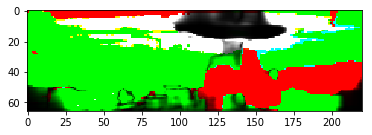

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[13.4855325]]
(66, 220, 3)
255.0
-46660.598


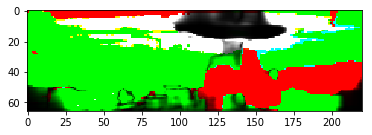

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[12.2288225]]
(66, 220, 3)
255.0
-48098.887


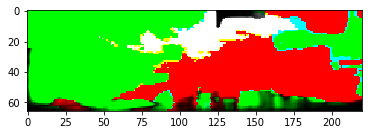

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[12.2288225]]
(66, 220, 3)
255.0
-48098.887


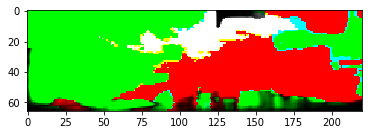

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[27.4903605]]
(66, 220, 3)
254.99998
-29854.74


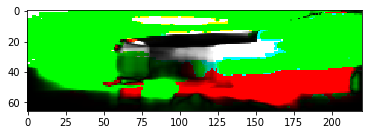

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[27.4903605]]
(66, 220, 3)
254.99998
-29854.74


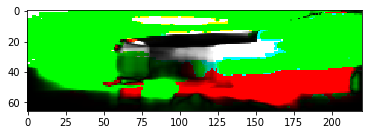

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[18.555655]]
(66, 220, 3)
255.00002
-39016.5


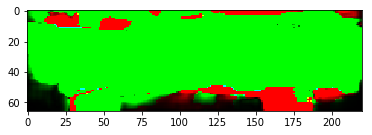

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[18.555655]]
(66, 220, 3)
255.00002
-39016.5


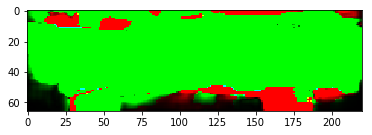

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[25.991041]]
(66, 220, 3)
255.0
-24990.0


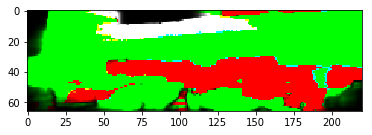

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[25.991041]]
(66, 220, 3)
255.0
-24990.0


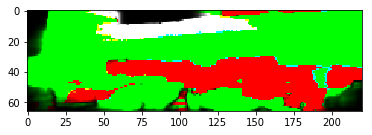

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[20.572921]]
(66, 220, 3)
254.99998
-37128.027


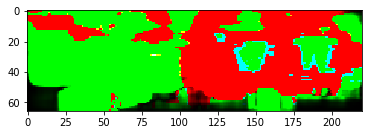

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[20.572921]]
(66, 220, 3)
254.99998
-37128.027


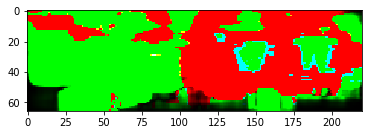

(1, 66, 220, 3)
[[15.5607685]]
(66, 220, 3)
255.0
-33930.98


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


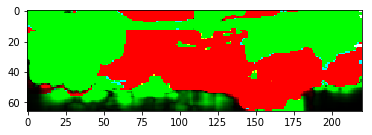

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[15.5607685]]
(66, 220, 3)
255.0
-33930.98


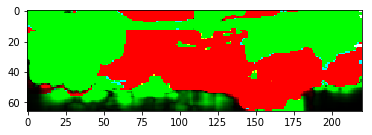

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.4389335]]
(66, 220, 3)
255.0
-31393.348


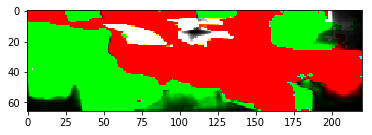

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.4389335]]
(66, 220, 3)
255.0
-31393.348


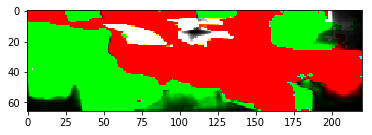

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.310203]]
(66, 220, 3)
255.0
-52478.418


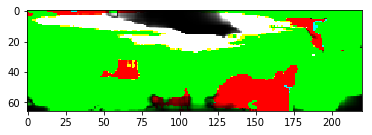

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.310203]]
(66, 220, 3)
255.0
-52478.418


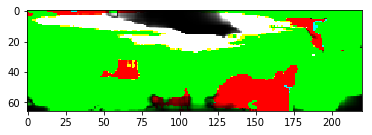

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[25.1072105]]
(66, 220, 3)
255.0
-31089.975


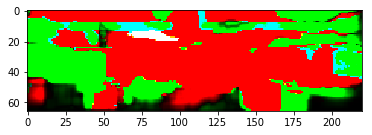

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[25.1072105]]
(66, 220, 3)
255.0
-31089.975


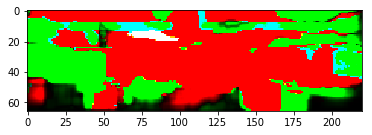

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[19.2585645]]
(66, 220, 3)
254.99998
-36715.19


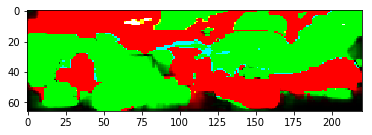

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[19.2585645]]
(66, 220, 3)
254.99998
-36715.19


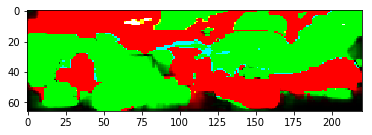

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.95345]]
(66, 220, 3)
255.0
-38989.19


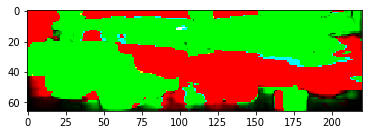

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.95345]]
(66, 220, 3)
255.0
-38989.19


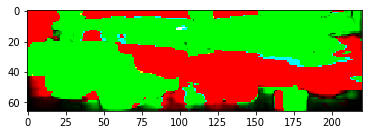

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[11.3612835]]
(66, 220, 3)
255.0
-51760.043


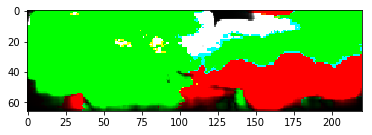

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[11.3612835]]
(66, 220, 3)
255.0
-51760.043


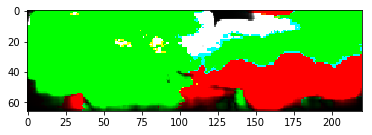

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[15.6618605]]
(66, 220, 3)
255.0
-41750.766


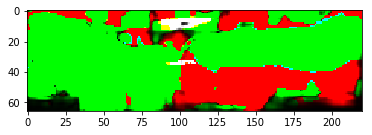

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[15.6618605]]
(66, 220, 3)
255.0
-41750.766


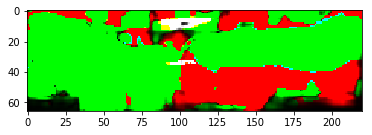

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.328239]]
(66, 220, 3)
255.0
-32619.674


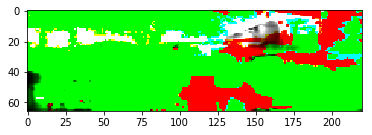

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[0.328239]]
(66, 220, 3)
255.0
-32619.674


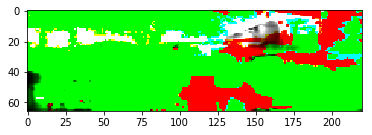

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[8.293261]]
(66, 220, 3)
255.0
-38553.03


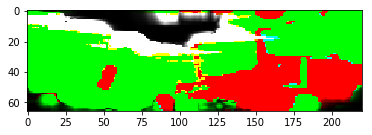

(1, 66, 220, 3)
[[8.293261]]
(66, 220, 3)
255.0
-38553.03


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


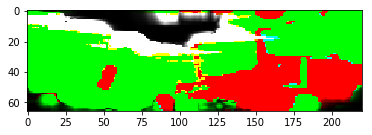

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[12.093097]]
(66, 220, 3)
255.0
-40769.707


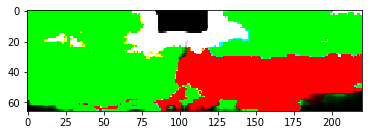

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[12.093097]]
(66, 220, 3)
255.0
-40769.707


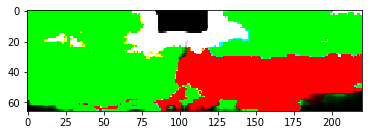

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[25.1948995]]
(66, 220, 3)
255.0
-31428.428


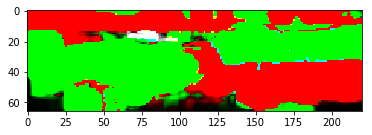

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[25.1948995]]
(66, 220, 3)
255.0
-31428.428


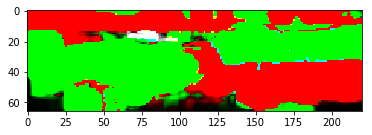

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[5.195217]]
(66, 220, 3)
255.0
-51656.92


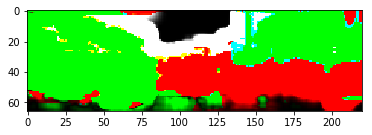

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[5.195217]]
(66, 220, 3)
255.0
-51656.92


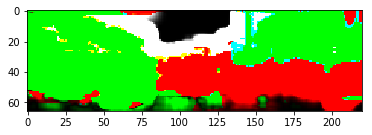

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[13.1136525]]
(66, 220, 3)
255.0
-50016.87


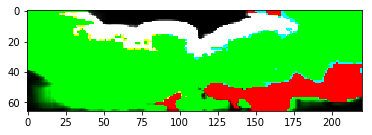

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[13.1136525]]
(66, 220, 3)
255.0
-50016.87


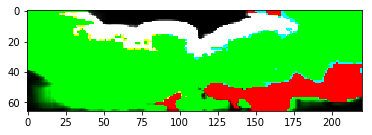

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[2.1523105]]
(66, 220, 3)
255.0
-47586.87


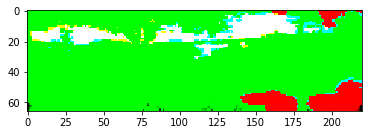

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[2.1523105]]
(66, 220, 3)
255.0
-47586.87


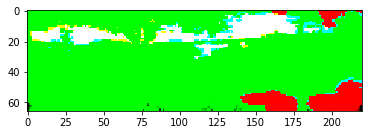

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.403579]]
(66, 220, 3)
255.0
-27436.445


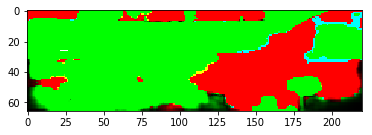

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[24.403579]]
(66, 220, 3)
255.0
-27436.445


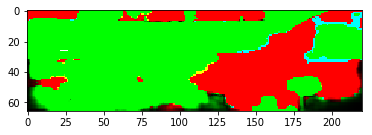

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.7160625]]
(66, 220, 3)
255.0
-49494.855


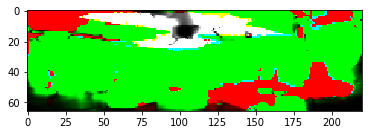

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.7160625]]
(66, 220, 3)
255.0
-49494.855


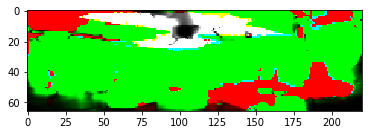

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.139281]]
(66, 220, 3)
255.0
-33489.305


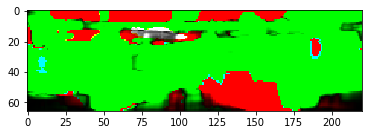

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.139281]]
(66, 220, 3)
255.0
-33489.305


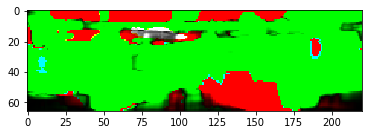

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[12.3969025]]
(66, 220, 3)
255.0
-30719.86


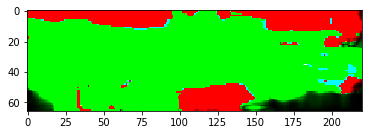

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[12.3969025]]
(66, 220, 3)
255.0
-30719.86


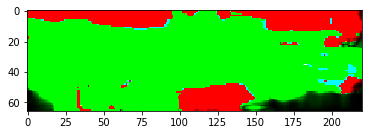

(1, 66, 220, 3)
[[3.751664]]
(66, 220, 3)
255.0
-56643.83


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


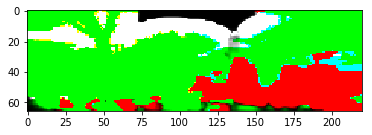

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[3.751664]]
(66, 220, 3)
255.0
-56643.83


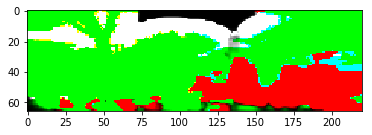

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.5000155]]
(66, 220, 3)
255.0
-28557.03


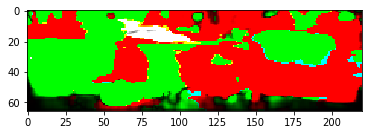

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[21.5000155]]
(66, 220, 3)
255.0
-28557.03


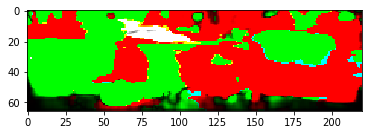

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.8085705]]
(66, 220, 3)
255.0
-35845.152


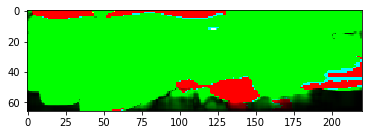

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[23.8085705]]
(66, 220, 3)
255.0
-35845.152


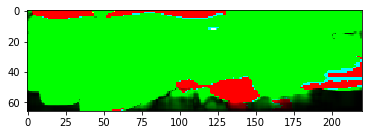

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.8349465]]
(66, 220, 3)
255.00002
-40290.004


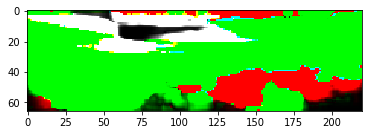

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.8349465]]
(66, 220, 3)
255.00002
-40290.004


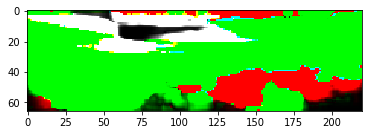

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[15.4819725]]
(66, 220, 3)
255.0
-30758.182


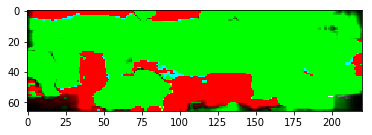

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[15.4819725]]
(66, 220, 3)
255.0
-30758.182


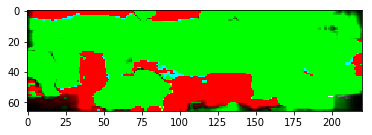

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[16.1857205]]
(66, 220, 3)
255.0
-27031.58


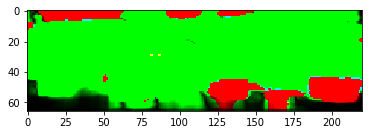

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[16.1857205]]
(66, 220, 3)
255.0
-27031.58


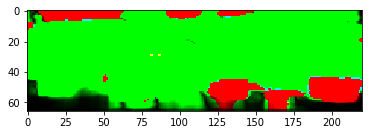

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[2.287526]]
(66, 220, 3)
255.0
-55502.145


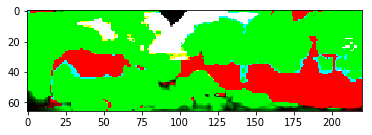

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[2.287526]]
(66, 220, 3)
255.0
-55502.145


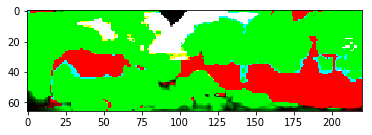

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.0357315]]
(66, 220, 3)
255.0
-35217.184


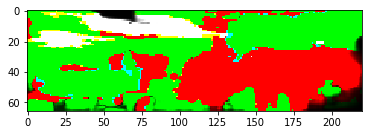

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.0357315]]
(66, 220, 3)
255.0
-35217.184


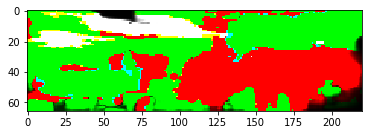

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.0953725]]
(66, 220, 3)
255.0
-41751.35


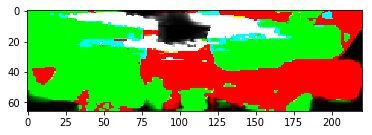

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[6.0953725]]
(66, 220, 3)
255.0
-41751.35


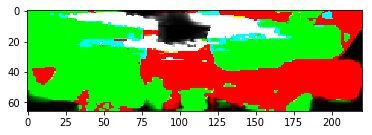

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.722493]]
(66, 220, 3)
255.00002
-25098.402


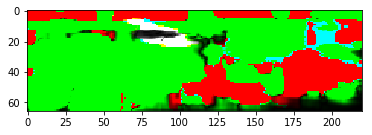

(1, 66, 220, 3)
[[22.722493]]
(66, 220, 3)
255.00002
-25098.402


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


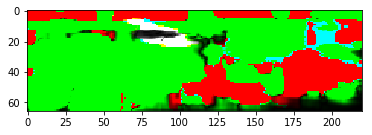

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[14.423878]]
(66, 220, 3)
254.99998
-56775.855


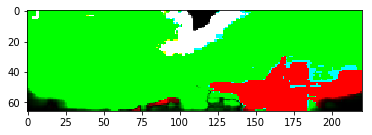

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[14.423878]]
(66, 220, 3)
254.99998
-56775.855


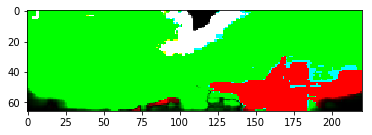

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[27.002899]]
(66, 220, 3)
255.0
-35440.434


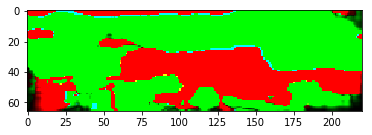

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[27.002899]]
(66, 220, 3)
255.0
-35440.434


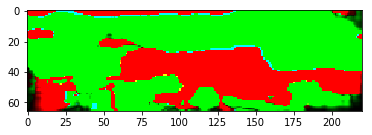

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.1013715]]
(66, 220, 3)
255.0
-32450.648


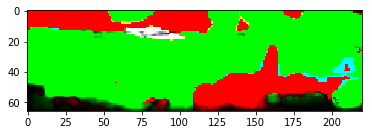

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.1013715]]
(66, 220, 3)
255.0
-32450.648


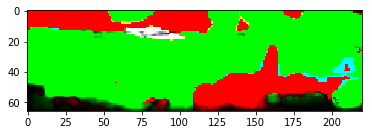

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.8037915]]
(66, 220, 3)
255.0
-23677.346


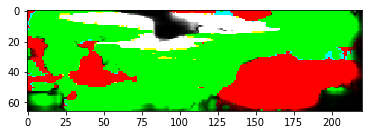

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.8037915]]
(66, 220, 3)
255.0
-23677.346


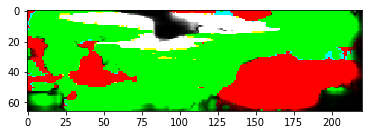

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.7471785]]
(66, 220, 3)
255.0
-26808.48


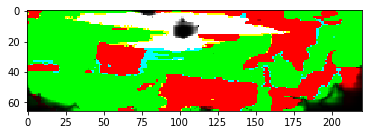

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[7.7471785]]
(66, 220, 3)
255.0
-26808.48


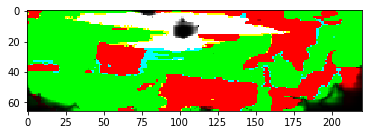

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.2641145]]
(66, 220, 3)
255.00002
-27297.105


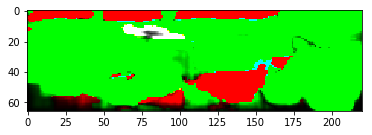

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[22.2641145]]
(66, 220, 3)
255.00002
-27297.105


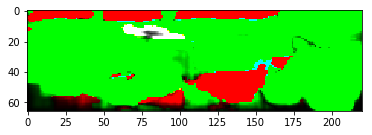

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 66, 220, 3)
[[14.35656]]
(66, 220, 3)
255.0
-46979.184


KeyboardInterrupt: 

In [22]:
for img_diff, speed in generate_validation_data(train_data):
    print(img_diff.shape)
    print(speed)
    img_diff = img_diff[0,:,:,:]
    #img_diff = np.swapaxes(img_diff, 0, 2)
    print(img_diff.shape)
    print(np.max(img_diff))
    print(np.min(img_diff))
    plt.imshow(img_diff)
    plt.show()

In [23]:
N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [24]:
if not os.path.exists(assets_filepath):
    os.makedirs(assets_filepath)

In [25]:
valid_generator = generate_validation_data(valid_data)
val_size = len(valid_data.index)

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=1, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(weights_loc, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
                            write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, tensorboard, earlyStopping]

In [26]:
model = nvidia_model()

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 220, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 108, 24)       1824      
_________________________________________________________________
elu_1 (ELU)                  (None, 31, 108, 24)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 52, 36)        21636     
_________________________________________________________________
elu_2 (ELU)                  (None, 14, 52, 36)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 24, 48)         43248     
_________________________________________________________________
elu_3 (ELU)                  (None, 5, 24, 48)         0         
__________

In [27]:
train_size = len(train_data.index)
train_generator = generate_training_data(train_data, batch_size)
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

print(history)

Epoch 1/25
400/400 [==============================] - 293s 732ms/step - loss: 34.6979 - val_loss: 94.8265

Epoch 00001: val_loss improved from inf to 94.82645, saving model to /home/ubuntu/repositories/speed-challenge/assets/model_assets/model=nvidia-batch_size=16-num_epoch=25-steps_per_epoch=400/weights.h5
Epoch 2/25
250/400 [=================>............] - ETA: 49s - loss: 6.0022

KeyboardInterrupt: 

In [32]:
# saving history
pickle.dump(history.history, open(history_loc, "wb"))

NameError: name 'history' is not defined

# Post Analysis

In [31]:
# model processing hyperparameters
batch_size = 16
num_epochs = 25 #100 #90 
steps_per_epoch = 400

# run specific constants
model_name = 'nvidia' #nvidia2
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch)

In [20]:
history = pickle.load(open(history_loc, "rb" ))
model.load_weights(weights_loc)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = adam, loss = 'mse')

In [21]:
val_score = model.evaluate_generator(valid_generator, steps=val_size)
print('val score:', val_score)

val score: 4.46276575222


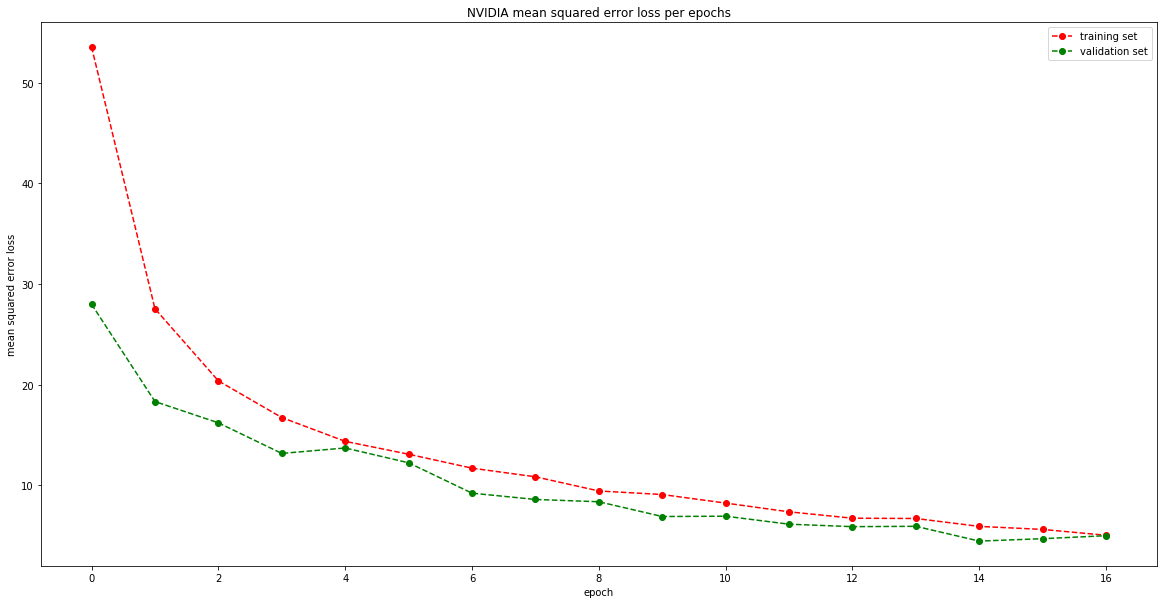

In [22]:
### plot the training and validation loss for each epoch
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history['loss'], 'ro--')
plt.plot(history['val_loss'], 'go--')
plt.title('NVIDIA mean squared error loss per epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

In [23]:
def make_predictions(data):
    for idx in tqdm(range(1, len(data.index)-1)):
        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        time_now = row_now['image_index'].values[0]
        time_prev = row_prev['image_index'].values[0]
        time_next = row_next['image_index'].values[0]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
        else:
            print('Error generating row')
        
        x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
        x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
        
        img_diff = opticalFlowDense(x1, x2)
        img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
        y = np.mean([y1, y2])

        prediction = model.predict(img_diff)
        error = abs(prediction-y2)
        
        
        #print(prediction, error, time_now)
        data.loc[data['image_index']==time_now, 'predicted_speed'] = prediction[0][0]
        data.loc[data['image_index']==time_now, 'error'] = error[0][0]

In [24]:
make_predictions(valid_data)

100%|██████████| 9030/9030 [03:00<00:00, 49.92it/s]


In [25]:
print(mean_squared_error(valid_data.iloc[1:-1, 3], 
                         valid_data.iloc[1:-1, 4]))

4.48619601782


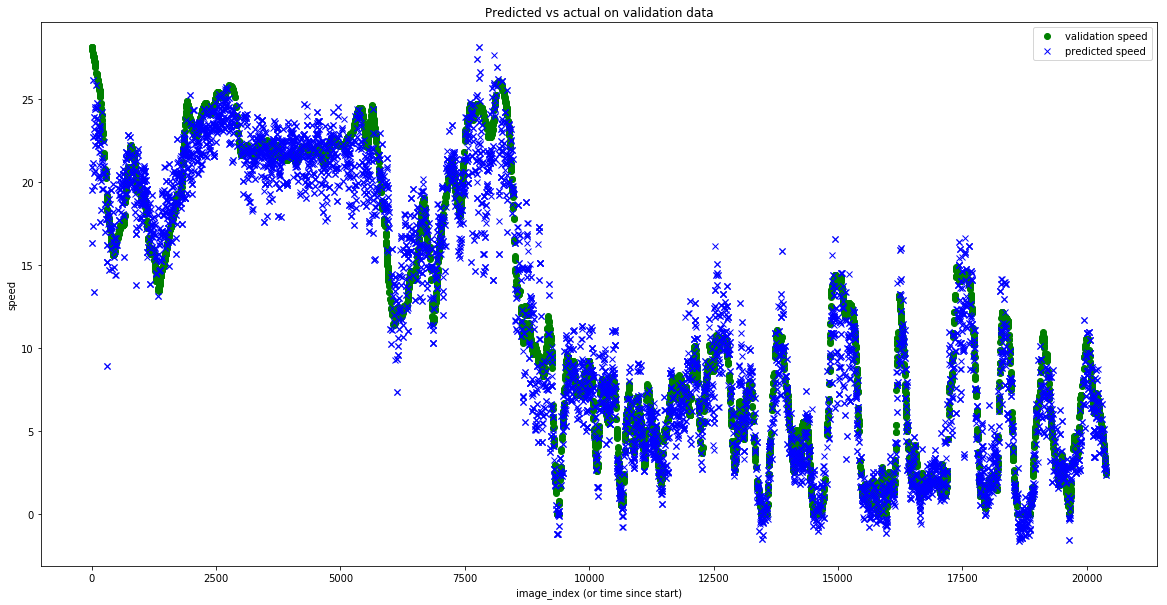

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on validation data')
plt.legend(['validation speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

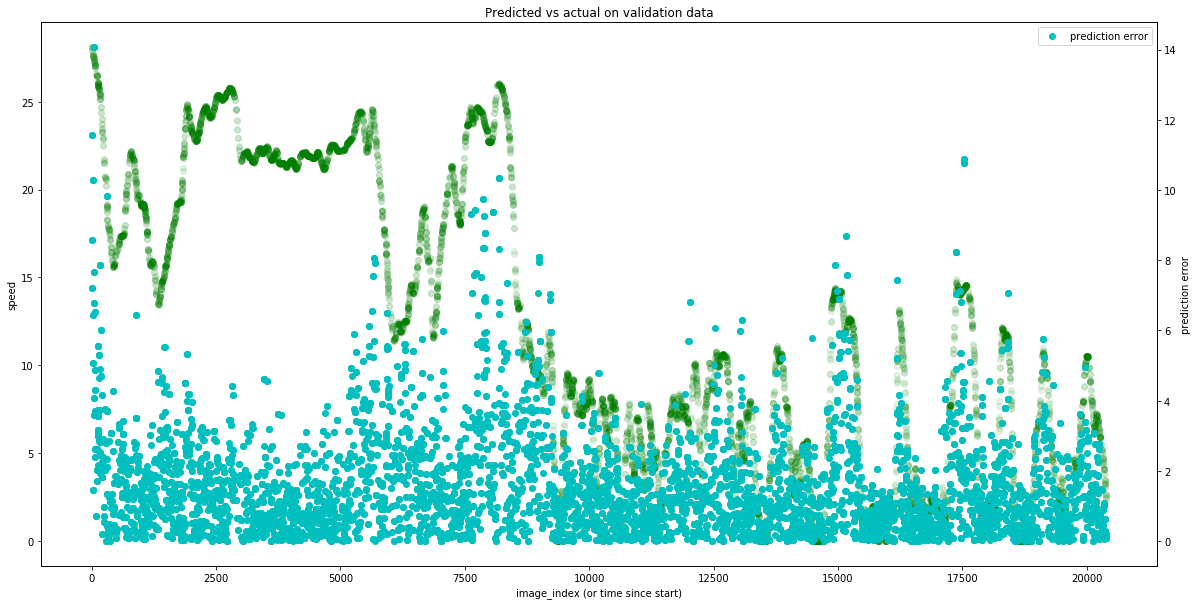

In [27]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.1)

ax2 = ax1.twinx()
ax2.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['error']], 'co')

ax1.set_xlabel('image_index (or time since start)')
ax1.set_ylabel('speed')
ax2.set_ylabel('prediction error')
plt.title('Predicted vs actual on validation data')
plt.legend(['prediction error'], loc='upper right')
plt.show()
plt.close()

In [28]:
def error_analysis(error_thresh):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(valid_data.sort_values(['image_index'])[['image_index']], 
             valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.4)


    ax.plot(valid_data[valid_data['error']>error_thresh].sort_values(['image_index'])[['image_index']], 
             valid_data[valid_data['error']>error_thresh].sort_values(['image_index'])[['speed']], 'rx')


    ax.set_xlabel('image_index (or time since start)')
    ax.set_ylabel('speed')
    plt.title('Error analysis on validation data')
    plt.legend(['Ground truth', 'Incorrect prediction'], loc='upper right')
    plt.show()

interact(error_analysis, error_thresh=(0,5, 0.1))

<function __main__.error_analysis>

## Predicting on Test

In [61]:
test_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'test_meta.csv'))
assert(test_meta.shape[0] == test_frames)
assert(test_meta.shape[1] == 3)
print('shape: ', test_meta.shape)

shape:  (10798, 3)


In [62]:
make_predictions(test_meta)

100%|██████████| 10796/10796 [03:37<00:00, 49.60it/s]


In [63]:
window_size = 25
test_meta['smooth_predicted_speed'] = pd.rolling_median(test_meta['predicted_speed'], window_size, center=True)
test_meta['smooth_error'] = test_meta.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)

test_meta['smooth_predicted_speed'] = test_meta.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)

test_meta['smooth_error'] = test_meta.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=25).median()
  


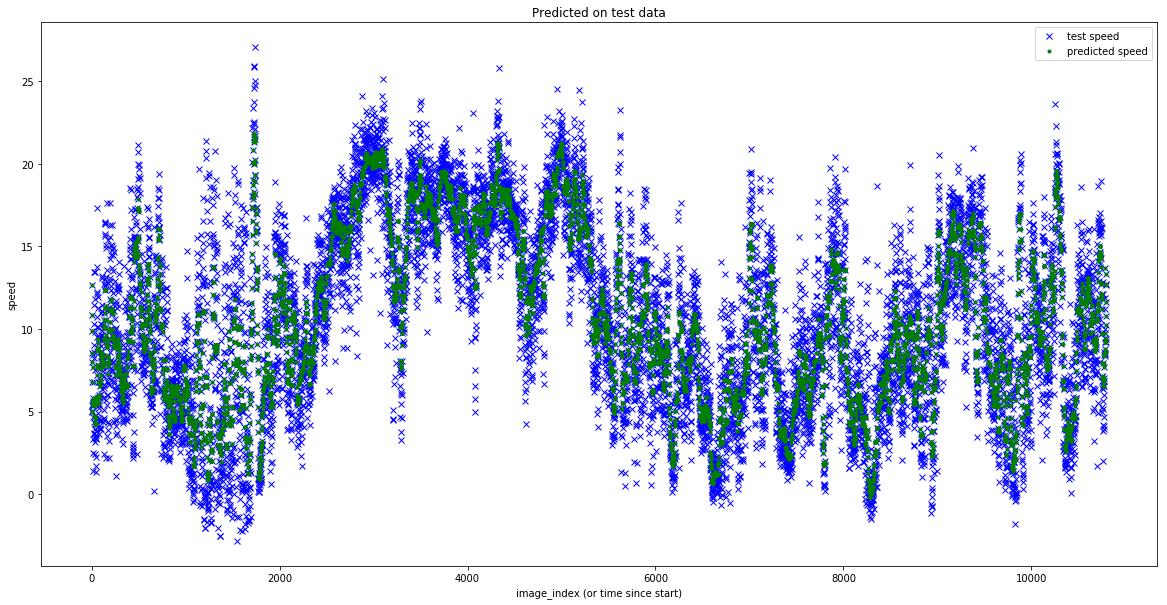

In [64]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['smooth_predicted_speed']], 'g.')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['test speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

In [77]:
output_file = test_meta['smooth_predicted_speed']
output_file.to_csv(os.path.join(ASSETS_PATH, 'test.txt'), index=False)

In [78]:
output_file.head()

0          NaN
1    10.822199
2     9.900039
3    12.636134
4     7.987153
Name: smooth_predicted_speed, dtype: float64

## Prediction on Train

In [29]:
make_predictions(train_meta)

100%|██████████| 20398/20398 [06:52<00:00, 49.48it/s]


In [36]:
train_meta.head()

image_path  image_index      speed  \
0  /kaggle/dev/speed-challenge-2017-data/clean_da...            0  28.105569   
1  /kaggle/dev/speed-challenge-2017-data/clean_da...            1  28.105569   
2  /kaggle/dev/speed-challenge-2017-data/clean_da...            2  28.106527   
3  /kaggle/dev/speed-challenge-2017-data/clean_da...            3  28.130404   
4  /kaggle/dev/speed-challenge-2017-data/clean_da...            4  28.109243   

   predicted_speed     error  smooth_predicted_speed  smooth_error  
0              NaN       NaN                     NaN           NaN  
1        18.869223  9.236347               18.869223      9.236347  
2        19.539047  8.567480               19.539047      8.567480  
3        19.182173  8.948231               19.182173      8.948231  
4        19.479349  8.629894               19.479349      8.629894

In [58]:
window_size = 25
train_meta['smooth_predicted_speed'] = pd.rolling_median(train_meta['predicted_speed'], window_size, center=True)
train_meta['smooth_error'] = train_meta.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)

train_meta['smooth_predicted_speed'] = train_meta.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)

train_meta['smooth_error'] = train_meta.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=25).median()
  


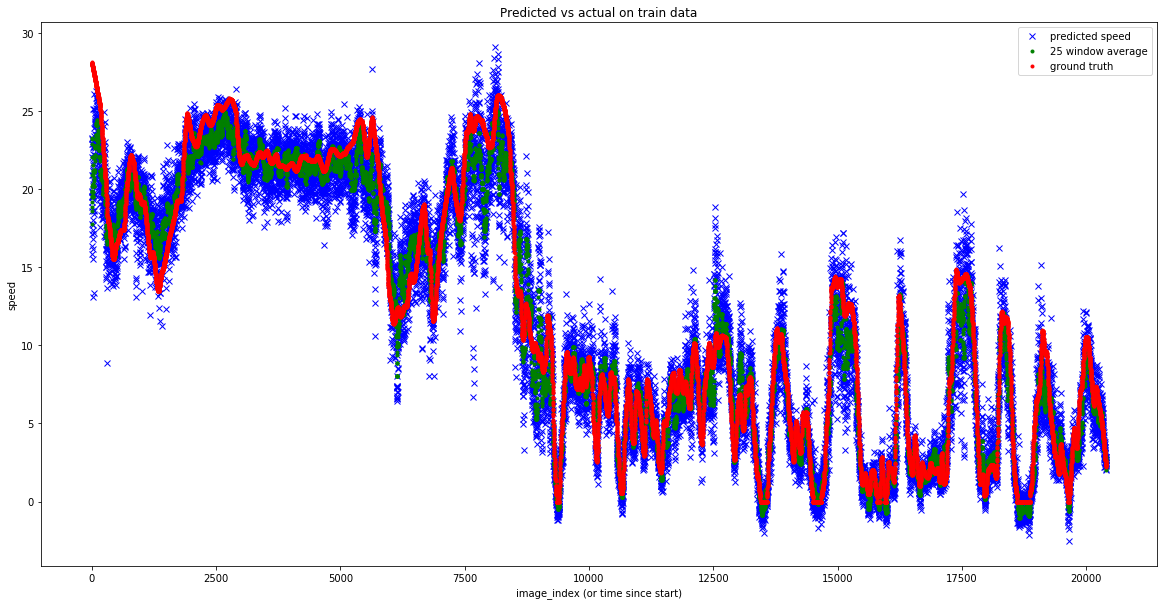

In [59]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_meta.sort_values(['image_index'])[['image_index']], 
         train_meta.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(train_meta.sort_values(['image_index'])[['image_index']], 
         train_meta.sort_values(['image_index'])[['smooth_predicted_speed']], 'g.')
plt.plot(train_meta.sort_values(['image_index'])[['image_index']], 
         train_meta.sort_values(['image_index'])[['speed']], 'r.')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on train data')
plt.legend(['predicted speed', (str(window_size) +' window average'), 'ground truth'], loc='upper right')
plt.show()
plt.close()

In [60]:
print(mean_squared_error(train_meta.iloc[1:-1, 2], 
                         train_meta.iloc[1:-1, 5]))

2.47529401414
